In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Utah 2018

## VEST Documentation

### Data Sources

> - Election results from OpenElections (http://openelections.net/)  
>- Shapefile from the Utah Automated Geographic Reference Center (https://gis.utah.gov/data/political/voter-precincts/)

### Election Processing

Several transcription errors were corrected from OpenElections using their raw results gathered from counties (https://github.com/openelections/openelections-sources-ut/tree/master/2018%20General%20Election). OE results in Rich and Morgan Counties were based on non-final reports, which were collected from county sources.

Emery County - 8 "canvas votes" were distributed to precincts.

Weber County - 6 precincts had their results suppressed, since all cast fewer than 15 votes, for a total of 42 votes. These were distributed based on the number of votes cast and the reported vote in 2016, which was not suppressed.

### Shapefile Processing

None

### Candidates

G18USSRROM - Mitt Romney (Republican Party)  
G18USSDWIL - Jenny Wilson (Democratic Party)  
G18USSIMCC - Reed C. McCandless (Independent American Party)  
G18USSLBOW - Craig R. Bowden (Libertarian Party)  
G18USSCAAL - Tim Aalders (Conservative Party)  
G18USSOWRI - Write-in Votes  

## Election Results

### Import files

In [2]:
#Load UT election results at the precinct level
ut_election_results = pd.read_csv('raw-from-source/20181106__ut__general__precinct.csv')

#Load the final VEST file
ut_vest = gp.read_file("raw-from-source/ut_2018/ut_2018.shp")

#Load the UT 2016 VEST file
ut_vest_2016 = gp.read_file("raw-from-source/ut_2016/ut_2016.shp")

#Load UT election results at the county level
ut_vest_county = pd.read_csv('raw-from-source/20181106__ut__general__county.csv')

### Filter down to needed races (just the Senate in this case)

In [3]:
ut_senators = ut_election_results[(ut_election_results['office'] == 'U.S. Senate') | (ut_election_results['office'] == 'U S Senate')]
display(ut_senators)

,county,precinct,office,district,candidate,party,votes
0,Wayne,Fremont,U.S. Senate,NaN,Tim Aalders,Con,7
1,Wayne,Loa in/out,U.S. Senate,NaN,Tim Aalders,Con,6
2,Wayne,Lyman in/out,U.S. Senate,NaN,Tim Aalders,Con,6
3,Wayne,Bicknell in/out,U.S. Senate,NaN,Tim Aalders,Con,8
4,Wayne,Teesdale,U.S. Senate,NaN,Tim Aalders,Con,3
...,...,...,...,...,...,...,...
41987,Morgan,Croydon 15.5,U S Senate,NaN,Craig R. Bowden,LIB,4
41988,Morgan,Croydon 15.5,U S Senate,NaN,Reed C. McCandless,IAP,0
41989,Morgan,Croydon 15.5,U S Senate,NaN,Jenny Wilson,DEM,6
41990,Morgan,Croydon 15.5,U S Senate,NaN,Mitt Romney,REP,65


### Clean up the candidate names

In [4]:
senators = (ut_senators['candidate'].unique())
print(senators)

['Tim Aalders' 'Craig Bowden' 'Reed McCandless' 'Jenny Wilson'
 'Mitt Romney' 'write-in' 'MITT ROMNEY' 'JENNY WILSON' 'CRAIG R.  BOWDEN'
 'TIM AALDERS' 'REED C. MCCANDLESS' 'WRITE-IN' 'CALEB DAN REEVE'
 'TYRONE JENSEN' 'GLADE G FITZGERALD' 'HEKTOR REIKSTHEGN' 'CODY JUDY'
 'RYAN DANIEL JACKSON' 'ABE KORB' 'Ryan Jackson' 'Craig R. Bowden'
 'Reed C. McCandless' 'Glade G Fitzgerald (W)' 'Caleb Dan Reeve (W)'
 'Hektor Reiksthegn (W)' 'Abe Korb (W)' 'Ryan Daniel Jackson (W)'
 'Cody Judy (W)' 'Tyrone Jensen (W)' 'Write In' 'Write-In Totals'
 'write-ins' 'Write-In Total' 'CRAIG R. BOWDEN' 'REED C. McCANDLESS'
 'Write-ins' 'Write-In' 'CRAIG R BOWDEN' 'REED C MCCANDLESS'
 'Caleb Dan Reeve' 'Write-In Votes']


### (Optional) Print votes for each candidate name

In [5]:
#pd.options.mode.chained_assignment = None  # default='warn'

#def find_votes(name):
    #df = (ut_senators[ut_senators['candidate']== name])
    #df.votes = pd.to_numeric(df.votes, errors='coerce')
    #return (df[df['votes'] > 0])
    
#for senator in senators:
    #df = find_votes(senator)
    #print(senator, 'has a total of', df.votes.sum(), 'in', len(df), 'precincts')

### Create a dictionary for name changes

Note: VEST options are: G18USSRROM, G18USSDWIL, G18USSIMCC, G18USSLBOW, G18USSCAAL, G18USSOWRI  
All not in major 5 parties - write-ins

In [6]:
senator_dict = {
    'Tim Aalders': 'G18USSCAAL',
    'TIM AALDERS': 'G18USSCAAL',
    
    'Craig Bowden': 'G18USSLBOW',
    'CRAIG R.  BOWDEN': 'G18USSLBOW',
    'CRAIG R BOWDEN': 'G18USSLBOW',
    'CRAIG R. BOWDEN': 'G18USSLBOW',
    'Craig R. Bowden': 'G18USSLBOW',
    
    'Reed McCandless': 'G18USSIMCC',
    'REED C. MCCANDLESS': 'G18USSIMCC',
    'REED C. McCANDLESS': 'G18USSIMCC', 
    'REED C MCCANDLESS': 'G18USSIMCC',
    'Reed C. McCandless': 'G18USSIMCC',
    
    'Jenny Wilson': 'G18USSDWIL',
    'JENNY WILSON': 'G18USSDWIL',
    
    'Mitt Romney': 'G18USSRROM',
    'MITT ROMNEY': 'G18USSRROM',
    
    'write-in': 'G18USSOWRI',
    'Write-ins': 'G18USSOWRI', 
    'Write-In': 'G18USSOWRI', 
    'Write-In Votes': 'G18USSOWRI',
    'Write In': 'G18USSOWRI', 
    'Write-In Totals': 'G18USSOWRI', 
    'write-ins': 'G18USSOWRI', 
    'Write-In Total': 'G18USSOWRI',
    'WRITE-IN': 'G18USSOWRI',
    
    'Tyrone Jensen (W)': 'G18USSOWRI',
    'TYRONE JENSEN': 'G18USSOWRI', 
    
    'GLADE G FITZGERALD': 'G18USSOWRI',
    'Glade G Fitzgerald (W)': 'G18USSOWRI',
    
    'HEKTOR REIKSTHEGN': 'G18USSOWRI',
    'Hektor Reiksthegn (W)': 'G18USSOWRI',
     
    'RYAN DANIEL JACKSON': 'G18USSOWRI',
    'Ryan Jackson': 'G18USSOWRI',
    'Ryan Daniel Jackson (W)': 'G18USSOWRI', 
    
    'ABE KORB': 'G18USSOWRI', 
    'Abe Korb (W)': 'G18USSOWRI',
     
    'Cody Judy (W)': 'G18USSOWRI',
    'CODY JUDY': 'G18USSOWRI',
    
    'Caleb Dan Reeve': 'G18USSOWRI',
    'CALEB DAN REEVE': 'G18USSOWRI',
    'Caleb Dan Reeve (W)': 'G18USSOWRI'
}

#### Apply the Dictionary to Names

Creates a column with standardized VEST codes for each candidate 

In [7]:
ut_senators['candidateid'] = ut_senators['candidate'].map(senator_dict).fillna(ut_senators['candidate'])
print(ut_senators['candidateid'].unique()) 

['G18USSCAAL' 'G18USSLBOW' 'G18USSIMCC' 'G18USSDWIL' 'G18USSRROM'
 'G18USSOWRI']


<ipython-input-7-6adc37fe5ea4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['candidateid'] = ut_senators['candidate'].map(senator_dict).fillna(ut_senators['candidate'])


### Add a county number column

All 29 counties in Utah are associated with a number between 1 and 29, in alphabetic order 

Here, we create two dictionaries - one that translates from county name to county num, and one that translates from county num to county name

In [8]:
counties = ut_vest_2016['county'].unique()
county_name_to_num = {}
for county in counties:
    if county not in county_name_to_num:
        county_name_to_num[county] = ut_vest_2016[ut_vest_2016['county'] == county].iloc[0]['CountyID']

    
county_num_to_name = {v: k for k, v in county_name_to_num.items()}
print(county_name_to_num)
print(len(county_num_to_name))
print(county_num_to_name)
print(len(county_num_to_name))

{'Beaver': 1, 'Box Elder': 2, 'Cache': 3, 'Carbon': 4, 'Daggett': 5, 'Davis': 6, 'Emery': 8, 'Garfield': 9, 'Iron': 11, 'Kane': 13, 'Millard': 14, 'Morgan': 15, 'Piute': 16, 'Rich': 17, 'San Juan': 19, 'Sanpete': 20, 'Sevier': 21, 'Summit': 22, 'Uintah': 24, 'Wayne': 28, 'Grand': 10, 'Juab': 12, 'Salt Lake': 18, 'Tooele': 23, 'Utah': 25, 'Wasatch': 26, 'Washington': 27, 'Weber': 29, 'Duchesne': 7}
29
{1: 'Beaver', 2: 'Box Elder', 3: 'Cache', 4: 'Carbon', 5: 'Daggett', 6: 'Davis', 8: 'Emery', 9: 'Garfield', 11: 'Iron', 13: 'Kane', 14: 'Millard', 15: 'Morgan', 16: 'Piute', 17: 'Rich', 19: 'San Juan', 20: 'Sanpete', 21: 'Sevier', 22: 'Summit', 24: 'Uintah', 28: 'Wayne', 10: 'Grand', 12: 'Juab', 18: 'Salt Lake', 23: 'Tooele', 25: 'Utah', 26: 'Wasatch', 27: 'Washington', 29: 'Weber', 7: 'Duchesne'}
29


### Create a countyid column which contains the numeric value of the county

In [9]:
ut_senators['countyid'] = ut_senators['county'].map(county_name_to_num)
county_names = ut_senators['county'].unique()
print("The number of unique county nums after mapping using the dictionary is:", len(county_names), 'which is exactly equal to the expected', len(county_name_to_num))

The number of unique county nums after mapping using the dictionary is: 29 which is exactly equal to the expected 29


<ipython-input-9-178881f505a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['countyid'] = ut_senators['county'].map(county_name_to_num)


### Cast the vote columns to integers 

Note: As is mentioned above, the surpressed votes are marked as "*"

In [10]:
def cast_to_int(num):
    if num != '*':
        return int(num)
    else:
        return '*'

ut_senators['votes'] = ut_senators['votes'].apply(cast_to_int)

<ipython-input-10-a86d0802983f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['votes'] = ut_senators['votes'].apply(cast_to_int)


### Create a pivot column

Explain how county + precinct = unique

In [11]:
ut_senators['mergeid'] = ut_senators['countyid'].astype(str)+'-'+ut_senators['precinct']

<ipython-input-11-9ada46d52f3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['mergeid'] = ut_senators['countyid'].astype(str)+'-'+ut_senators['precinct']


### Perform the pivot

pivot on mergeid column with unique id's for each precinct

In [12]:
pivoted_2018 = pd.pivot_table(ut_senators,values=["votes"],index=["mergeid"],columns=["candidateid"],aggfunc=sum)
pivoted_2018=pivoted_2018.fillna(0)
pivoted_2018.reset_index(drop=False,inplace=True)
#pivoted_2018.columns = pivoted_2018.columns.droplevel(0)

pivoted_2018.columns = ['joinid', 'G18USSCAAL', 'G18USSDWIL', 'G18USSIMCC', 'G18USSLBOW', 'G18USSOWRI', 'G18USSRROM']
display(pivoted_2018)
#pivoted_2018.to_csv('./pivoted_2018.csv')

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
2266,9-Henrieville HE6:1,3,14,0,2,0,94
2267,9-Panguitch 1 PA7:1,18,37,3,12,0,374
2268,9-Panguitch 2 PA8:1,11,28,4,2,0,315
2269,9-Ticaboo TI9:1,0,4,0,1,0,10


### Remove Total/Canvas votes

Counties that have totals row are: 11, 13, 21

In [13]:
totals_joinid = ['11-IRON UT', '13-TOTALS', '21-TOTALS']
list_of_candidates = ['G18USSCAAL','G18USSDWIL','G18USSIMCC','G18USSLBOW','G18USSOWRI','G18USSRROM']

#validate that each counties votes add up to totals

#County 11
df11 = pivoted_2018[pivoted_2018.joinid.str.startswith('11-')]
df11_total = df11[df11.joinid == '11-IRON UT']
df11_non_total = df11.drop(df11_total.index)
df11_non_total.loc["totals"] = df11_non_total.sum(axis = 0)
display(df11_non_total.loc['totals'])
display(df11_total)
for cand in list_of_candidates:
    print('For county 11 and race', cand)
    print('The totals provided by the totals row are:', int(df11_total[cand]))
    print('The totals as a result of the sum of the votes in each precinct are:', df11_non_total.loc['totals'][cand])
    print('And their difference is:', (int(df11_total[cand]) - df11_non_total.loc['totals'][cand]))
    print()
    
#County 13
df13 = pivoted_2018[pivoted_2018.joinid.str.startswith('13-')]
df13_total = df13[df13.joinid == '13-TOTALS']
df13_non_total = df13.drop(df13_total.index)
df13_non_total.loc["totals"] = df13_non_total.sum(axis = 0)
display(df13_non_total.loc['totals'])
display(df13_total)
for cand in list_of_candidates:
    print('For county 13 and race', cand)
    print('The totals provided by the totals row are:', int(df13_total[cand]))
    print('The totals as a result of the sum of the votes in each precinct are:', df13_non_total.loc['totals'][cand])
    print('And their difference is:', (int(df13_total[cand]) - df13_non_total.loc['totals'][cand]))
    print()
    
#County 21
df21 = pivoted_2018[pivoted_2018.joinid.str.startswith('21-')]
df21_total = df21[df21.joinid == '21-TOTALS']
df21_non_total = df21.drop(df21_total.index)
df21_non_total.loc["totals"] = df21_non_total.sum(axis = 0)
display(df21_non_total.loc['totals'])
display(df21_total)
for cand in list_of_candidates:
    print('For county 21 and race', cand)
    print('The totals provided by the totals row are:', int(df21_total[cand]))
    print('The totals as a result of the sum of the votes in each precinct are:', df21_non_total.loc['totals'][cand])
    print('And their difference is:', (int(df21_total[cand]) - df21_non_total.loc['totals'][cand]))
    print()

joinid        11-BH11-BRYL11-CC0111-CC0211-CC0311-CC0411-CC0...
G18USSCAAL                                                  866
G18USSDWIL                                                 2846
G18USSIMCC                                                  206
G18USSLBOW                                                  597
G18USSOWRI                                                   68
G18USSRROM                                                11286
Name: totals, dtype: object

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
59,11-IRON UT,866,2846,206,597,68,11286


For county 11 and race G18USSCAAL
The totals provided by the totals row are: 866
The totals as a result of the sum of the votes in each precinct are: 866
And their difference is: 0

For county 11 and race G18USSDWIL
The totals provided by the totals row are: 2846
The totals as a result of the sum of the votes in each precinct are: 2846
And their difference is: 0

For county 11 and race G18USSIMCC
The totals provided by the totals row are: 206
The totals as a result of the sum of the votes in each precinct are: 206
And their difference is: 0

For county 11 and race G18USSLBOW
The totals provided by the totals row are: 597
The totals as a result of the sum of the votes in each precinct are: 597
And their difference is: 0

For county 11 and race G18USSOWRI
The totals provided by the totals row are: 68
The totals as a result of the sum of the votes in each precinct are: 68
And their difference is: 0

For county 11 and race G18USSRROM
The totals provided by the totals row are: 11286
The tot

joinid        13-AL13-BU13-BW13-CM13-CW:B13-CW:C13-GL13-K113...
G18USSCAAL                                                  109
G18USSDWIL                                                  746
G18USSIMCC                                                   38
G18USSLBOW                                                   89
G18USSOWRI                                                    6
G18USSRROM                                                 2135
Name: totals, dtype: object

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
100,13-TOTALS,109,746,38,89,6,2135


For county 13 and race G18USSCAAL
The totals provided by the totals row are: 109
The totals as a result of the sum of the votes in each precinct are: 109
And their difference is: 0

For county 13 and race G18USSDWIL
The totals provided by the totals row are: 746
The totals as a result of the sum of the votes in each precinct are: 746
And their difference is: 0

For county 13 and race G18USSIMCC
The totals provided by the totals row are: 38
The totals as a result of the sum of the votes in each precinct are: 38
And their difference is: 0

For county 13 and race G18USSLBOW
The totals provided by the totals row are: 89
The totals as a result of the sum of the votes in each precinct are: 89
And their difference is: 0

For county 13 and race G18USSOWRI
The totals provided by the totals row are: 6
The totals as a result of the sum of the votes in each precinct are: 6
And their difference is: 0

For county 13 and race G18USSRROM
The totals provided by the totals row are: 2135
The totals as a 

joinid        21-Annabella 121-Aurora 221-Central Valley 421...
G18USSCAAL                                                  408
G18USSDWIL                                                  771
G18USSIMCC                                                  113
G18USSLBOW                                                  173
G18USSOWRI                                                   50
G18USSRROM                                                 5810
Name: totals, dtype: object

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
1047,21-TOTALS,408,771,113,173,50,5810


For county 21 and race G18USSCAAL
The totals provided by the totals row are: 408
The totals as a result of the sum of the votes in each precinct are: 408
And their difference is: 0

For county 21 and race G18USSDWIL
The totals provided by the totals row are: 771
The totals as a result of the sum of the votes in each precinct are: 771
And their difference is: 0

For county 21 and race G18USSIMCC
The totals provided by the totals row are: 113
The totals as a result of the sum of the votes in each precinct are: 113
And their difference is: 0

For county 21 and race G18USSLBOW
The totals provided by the totals row are: 173
The totals as a result of the sum of the votes in each precinct are: 173
And their difference is: 0

For county 21 and race G18USSOWRI
The totals provided by the totals row are: 50
The totals as a result of the sum of the votes in each precinct are: 50
And their difference is: 0

For county 21 and race G18USSRROM
The totals provided by the totals row are: 5810
The totals

Since all of the votes add up to their respective totals, we can remove the totals row before merging with the vest file

In [14]:
pivoted_2018 = pivoted_2018.drop(pivoted_2018[pivoted_2018.joinid == '11-IRON UT'].index)
pivoted_2018 = pivoted_2018.drop(pivoted_2018[pivoted_2018.joinid == '13-TOTALS'].index)
pivoted_2018 = pivoted_2018.drop(pivoted_2018[pivoted_2018.joinid == '21-TOTALS'].index)

In [15]:
display(pivoted_2018)

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
2266,9-Henrieville HE6:1,3,14,0,2,0,94
2267,9-Panguitch 1 PA7:1,18,37,3,12,0,374
2268,9-Panguitch 2 PA8:1,11,28,4,2,0,315
2269,9-Ticaboo TI9:1,0,4,0,1,0,10


## Joining election results to VEST

### Take a look at the VEST file

In [16]:
print(ut_vest.head())

   CountyID mergeid uniqueid  G18USSRROM  G18USSDWIL  G18USSIMCC  G18USSLBOW  \
0         1    BV01   1-BV01         402          46           8           9   
1         1    BV02   1-BV02         310          46           3          10   
2         1    BV03   1-BV03         244          30           0           2   
3         1    BV04   1-BV04          84           7           1           4   
4         1    GR01   1-GR01          56           9           6           1   

   G18USSCAAL  G18USSOWRI                                           geometry  
0          19           1  POLYGON ((358362.560 4238423.840, 358372.350 4...  
1          17           0  POLYGON ((355866.750 4240506.080, 356860.230 4...  
2          12           2  POLYGON ((358902.400 4261055.000, 358909.700 4...  
3          23           0  POLYGON ((367866.500 4262536.100, 367842.500 4...  
4           1           1  POLYGON ((348977.460 4223848.220, 348973.090 4...  


### Create a joinid similar to the one created above

Note, there is already a "uniqueid" column, but creating our own allows us to avoid its idiosyncracies

In [17]:
ut_vest['joinid'] = ut_vest['CountyID'].astype(str)+'-'+ut_vest['mergeid']

### Attempt to join

In [18]:
join_attempt_one = pd.merge(ut_vest,pivoted_2018,how="outer",on="joinid",indicator=True)
print(join_attempt_one["_merge"].value_counts())

right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
merged = join_attempt_one[join_attempt_one["_merge"]=="both"]

#left_only.to_csv("./only_vest.csv")
#right_only.to_csv("./only_source.csv")
#merged.to_csv("./merged_votes.csv")

both          1693
left_only      644
right_only     575
Name: _merge, dtype: int64


### Change names to increase matches

In [19]:
joinid_dict = {'1-Beaver 1': '1-BV01',
 '1-Beaver 2': '1-BV02',
 '1-Beaver 3': '1-BV03',
 '1-Beaver 4': '1-BV04',
 '1-Greenville': '1-GR01',
 '1-Milford 1': '1-ML01',
 '1-Milford 2': '1-ML02',
 '1-Milford 3': '1-ML03',
 '1-Minersville': '1-MV01',
 '2-Brigham City 01': '2-BC01',
 '2-Brigham City 02': '2-BC02',
 '2-Brigham City 03': '2-BC03',
 '2-Brigham City 04': '2-BC04',
 '2-Brigham City 05': '2-BC05',
 '2-Brigham City 06': '2-BC06',
 '2-Brigham City 07': '2-BC07',
 '2-Brigham City 08': '2-BC08',
 '2-Brigham City 09': '2-BC09',
 '2-Brigham City 10': '2-BC10',
 '2-Brigham City 11': '2-BC11',
 '2-Brigham City 12': '2-BC12',
 '2-Brigham City 13': '2-BC13',
 '2-Brigham City 14': '2-BC14',
 '2-Brigham City 15': '2-BC15',
 '2-Brigham City North': '2-BCN',
 '2-Beaver Dam/Collinston': '2-BD/C',
 '2-Bear River': '2-BEAR',
 '2-Bear River East': '2-BRE',
 '2-Clear Creek': '2-CC',
 '2-Corinne 1': '2-COR1',
 '2-Corinne 2': '2-COR2',
 '2-Deweyville': '2-DEWY',
 '2-Elwood': '2-ELWD',
 '2-Fielding 1': '2-FLDG1',
 '2-Fielding 2': '2-FLDG2',
 '2-Garland 1': '2-GAR1',
 '2-Garland 2': '2-GAR2',
 '2-Garland East': '2-GARE',
 '2-Grouse Creek': '2-GC',
 '2-Honeyville': '2-HONY',
 '2-Howell': '2-HOWL',
 '2-Mantua': '2-MANT',
 '2-Park Valley': '2-PARK',
 '2-Perry 1': '2-PER1',
 '2-Perry 2': '2-PER2',
 '2-Perry 3': '2-PER3',
 '2-Perry 4': '2-PER4',
 '2-Plymouth': '2-PLYM',
 '2-Portage': '2-PORT',
 '2-Promontory': '2-PROM',
 '2-Riverside': '2-RIV',
 '2-Snowville': '2-SNOW',
 '2-South Willard': '2-SWIL',
 '2-Tremonton 1': '2-TRE1',
 '2-Tremonton 2': '2-TRE2',
 '2-Tremonton 3': '2-TRE3',
 '2-Tremonton 4': '2-TRE4',
 '2-Tremonton 5': '2-TRE5',
 '2-Tremonton South': '2-TRES',
 '2-Tremonton West': '2-TREW',
 '2-Yost': '2-YOST',
 '3-LOG01-CSD': '3-LOG01:CSD',
 '3-LOG01-1': '3-LOG01:I',
 '3-LOG27-17C': '3-LOG27:17C',
 '3-LOG37-CSD': '3-LOG27:CSD',
 '3-LOG27-1': '3-LOG27:I',
 '3-LOG27-U': '3-LOG27:U',
 '3-LOG29-CSD': '3-LOG29:CSD',
 '3-LOG29-1': '3-LOG29:I',
 '3-LOG33-5': '3-LOG33:5',
 '3-LOG33-CSD': '3-LOG33:CSD',
 '3-LOG33-1': '3-LOG33:I',
 '4-02 Scofield': '4-2',
 '4-03 Pleasant Valley': '4-3',
 '4-07 East Helper': '4-7',
 '4-16 South Price': '4-16',
 '4-17 East Price': '4-17',
 '4-19 Wellington': '4-19',
 '4-20 East Carbon': '4-20',
 '4-21 West Helper': '4-21',
 '4-22 East County': '4-22',
 '4-27 Fairgrounds': '4-27',
 '4-30 Castle Hts North': '4-30',
 '4-31 Central Price': '4-31',
 '4-32 North East Pric': '4-32',
 '4-33 North Price': '4-33',
 '4-34 Castle Heights': '4-34',
 '4-36 South County': '4-36',
 '4-37 Spring Glen': '4-37',
 '4-38 Carbonville': '4-38',
 '4-39 Westwood': '4-39',
 '4-40 Miller Creek': '4-40',
 '5-1001:DS1, SD1': '5-1001:DS1,SD1',
 '5-1001:DS2, SD2': '5-1001:DS2,SD2',
 '6-BO01:I-S-': '6-BO01',
 '6-BO02:I-S-': '6-BO02',
 '6-BO03:I-S-': '6-BO03',
 '6-BO05:I-S-': '6-BO05',
 '6-BO06:I-S-': '6-BO06',
 '6-BO07:I-S-': '6-BO07',
 '6-BO08:I-S-': '6-BO08',
 '6-BO09:I-S-': '6-BO09',
 '6-BO11:I-S-': '6-BO11',
 '6-BO12:I-S-': '6-BO12',
 '6-BO13:I-S-': '6-BO13',
 '6-BO14:I-S-': '6-BO14',
 '6-BO15:I-S-': '6-BO15',
 '6-BO16:I-S-': '6-BO16',
 '6-BO19:I-S-': '6-BO19',
 '6-BO20:I-S-': '6-BO20',
 '6-BO21:I-S-': '6-BO21',
 '6-BO22:I-S-': '6-BO22',
 '6-BO24:I-S-': '6-BO24',
 '6-BO26:IDS-': '6-BO26',
 '6-BO27:I-S-': '6-BO27',
 '6-BO32:I-S-': '6-BO32',
 '6-BO33:I-S-': '6-BO33',
 '6-CE01:I-S-': '6-CE01',
 '6-CE03:I-S-': '6-CE03',
 '6-CE06:I-S-': '6-CE06',
 '6-CE07:I-S-': '6-CE07',
 '6-CE09:I-S-': '6-CE09',
 '6-CE10:I-S-': '6-CE10',
 '6-CE12:I-S-': '6-CE12',
 '6-CF01:I-N-': '6-CF01',
 '6-CF02:I-N-': '6-CF02',
 '6-CF03:I-N-': '6-CF03',
 '6-CF04:I-N-': '6-CF04',
 '6-CF05:I-N-': '6-CF05',
 '6-CF06:I-N-': '6-CF06',
 '6-CF07:I-N-': '6-CF07',
 '6-CF08:I-N-': '6-CF08',
 '6-CF09:I-N-': '6-CF09',
 '6-CF11:I-N-': '6-CF11',
 '6-CF12:I-N-': '6-CF12',
 '6-CF13:I-N-': '6-CF13',
 '6-CF14:I-N-': '6-CF14',
 '6-CF15:I-N-': '6-CF15',
 '6-CF16:I-N-': '6-CF16',
 '6-CF17:I-N-': '6-CF17',
 '6-CL01:I-N-': '6-CL01',
 '6-CL02:I-N-': '6-CL02',
 '6-CL04:I-N-': '6-CL04',
 '6-CL05:I-N-': '6-CL05',
 '6-CL06:I-N-': '6-CL06',
 '6-CL07:I-N-': '6-CL07',
 '6-CL08:I-N-': '6-CL08',
 '6-CL09:I-N-': '6-CL09',
 '6-CL10:I-N-': '6-CL10',
 '6-CL11:I-N-': '6-CL11',
 '6-CL12:I-N-': '6-CL12',
 '6-CL13:I-N-': '6-CL13',
 '6-FA03:I-C-': '6-FA03',
 '6-FA05:IBC-': '6-FA05',
 '6-FA07:IBC-': '6-FA07',
 '6-FA09:IBC-': '6-FA09',
 '6-FA11:IBC-': '6-FA11',
 '6-FA13:IBC-': '6-FA13',
 '6-FA14:I-C-': '6-FA14',
 '6-FA15:IBC-': '6-FA15',
 '6-FA16:IBC-': '6-FA16',
 '6-FH01:I-C-': '6-FH01',
 '6-FH05:I-C-': '6-FH05',
 '6-HA03:U-N-': '6-HA03',
 '6-KA01:I-C-': '6-KA01',
 '6-KA02:I-C-': '6-KA02',
 '6-KA03:I-C-': '6-KA03',
 '6-KA04:I-C-': '6-KA04',
 '6-KA07:I-C-': '6-KA07',
 '6-KA10:I-C-': '6-KA10',
 '6-KA13:IBC-': '6-KA13',
 '6-KA15:IBC-': '6-KA15',
 '6-KA16:IBC-': '6-KA16',
 '6-KA18:I-C-': '6-KA18',
 '6-KA22:I-C-': '6-KA22',
 '6-LA03:I-N-': '6-LA03',
 '6-LA05:I-N-': '6-LA05',
 '6-LA06:I-N-': '6-LA06',
 '6-LA07:I-N-': '6-LA07',
 '6-LA08:I-N-': '6-LA08',
 '6-LA10:I-N-': '6-LA10',
 '6-LA11:I-N-': '6-LA11',
 '6-LA12:I-N-': '6-LA12',
 '6-LA13:I-N-': '6-LA13',
 '6-LA14:I-N-': '6-LA14',
 '6-LA15:I-N-': '6-LA15',
 '6-LA16:I-N-': '6-LA16',
 '6-LA17:I-N-': '6-LA17',
 '6-LA18:I-N-': '6-LA18',
 '6-LA19:I-N-': '6-LA19',
 '6-LA20:I-N-': '6-LA20',
 '6-LA21:I-N-': '6-LA21',
 '6-LA22:I-N-': '6-LA22',
 '6-LA23:I-N-': '6-LA23',
 '6-LA25:I-N-': '6-LA25',
 '6-LA26:I-N-': '6-LA26',
 '6-LA27:I-N-': '6-LA27',
 '6-LA28:I-N-': '6-LA28',
 '6-LA29:I-N-': '6-LA29',
 '6-LA30:I-N-': '6-LA30',
 '6-LA31:I-N-': '6-LA31',
 '6-LA32:I-N-': '6-LA32',
 '6-LA40:I-N-': '6-LA40',
 '6-LA42:I-N-': '6-LA42',
 '6-LA43:I-N-': '6-LA43',
 '6-LA45:I-N-': '6-LA45',
 '6-LA46:I-N-': '6-LA46',
 '6-LA47:I-N-': '6-LA47',
 '6-NS01:I-S-': '6-NS01',
 '6-NS04:I-S-': '6-NS04',
 '6-NS07:UDS-': '6-NS07',
 '6-NS09:I-S-': '6-NS09',
 '6-NS10:I-S-': '6-NS10',
 '6-NS11:I-S-': '6-NS11',
 '6-SU01:I-N-': '6-SU01',
 '6-SU02:I-N-': '6-SU02',
 '6-SU03:I-N-': '6-SU03',
 '6-SW04:U---': '6-SW04',
 '6-SY01:I-N-': '6-SY01',
 '6-SY03:I-N-': '6-SY03',
 '6-SY04:I-N-': '6-SY04',
 '6-SY05:I-N-': '6-SY05',
 '6-SY06:I-N-': '6-SY06',
 '6-SY07:I-N-': '6-SY07',
 '6-SY08:I-N-': '6-SY08',
 '6-SY10:I-N-': '6-SY10',
 '6-SY12:I-N-': '6-SY12',
 '6-SY13:I-N-': '6-SY13',
 '6-SY14:I-N-': '6-SY14',
 '6-SY15:I-N-': '6-SY15',
 '6-SY16:I-N-': '6-SY16',
 '6-SY17:I-N-': '6-SY17',
 '6-SY18:I-N-': '6-SY18',
 '6-SY19:I-N-': '6-SY19',
 '6-WB01:I-S-': '6-WB01',
 '6-WB02:I-S-': '6-WB02',
 '6-WB03:I-S-': '6-WB03',
 '6-WP01:I-N-': '6-WP01',
 '6-WP03:I-N-': '6-WP03',
 '6-WP04:I-N-': '6-WP04',
 '6-WP06:I-N-': '6-WP06',
 '6-WP08:I-N-': '6-WP08',
 '6-WX02:I-S-': '6-WX02',
 '6-WX03:I-S-': '6-WX03',
 '6-WX05:I-S-': '6-WX05',
 '6-WX07:I-S-': '6-WX07',
 '7-RO92': '7-R092',
 '8-Emery 1': '8-1',
 '8-Cleveland 10': '8-10',
 '8-Elmo 11': '8-11',
 '8-Green River 12': '8-12',
 '8-Ferron 2': '8-2',
 '8-Ferron 3': '8-3',
 '8-Clawson 4': '8-4',
 '8-Orangeville 5': '8-5',
 '8-Castle Dale 6': '8-6',
 '8-Castle Dale 7': '8-7',
 '8-Huntington 8': '8-8',
 '8-Huntington 9': '8-9',
 '9-Antimony AN1:1': '9-AN1',
 '9-Boulder BO2:1': '9-BO2',
 '9-Bryce Canyon City BR11:1': '9-BR11',
 '9-Cannonville CA3:1': '9-CA3',
 '9-Escalante ES4:1': '9-ES4',
 '9-Hatch HA5:1': '9-HA5',
 '9-Henrieville HE6:1': '9-HE6',
 '9-Panguitch 1 PA7:1': '9-PA7',
 '9-Panguitch 2 PA8:1': '9-PA8',
 '9-Ticaboo TI9:1': '9-TI9',
 '9-Tropic TR10:1': '9-TR10',
 '10-01 Moab 1:70': '10-01:70',
 '10-02 Moab 2:69': '10-02:69',
 '10-03 Moab 2:70': '10-02:70',
 '10-04 Moab 3:70': '10-03:70',
 '10-05 Moab 4:69': '10-04:69',
 '10-06 Moab 4:70': '10-04:70',
 '10-07 Moab 5:69': '10-05:69',
 '10-08 Moab 5:70': '10-05:70',
 '10-09 Thompson 6:69': '10-06:69',
 '10-10 Thompson 6:70': '10-06:70',
 '10-11 Green River 7:69': '10-07:69',
 '10-12 Green River 7:70': '10-07:70',
 '10-13 Castle Valley 8:69': '10-08:69',
 '10-14 Moab 9:69': '10-09:69',
 '10-15 Moab 9:70': '10-09:70',
 '10-16 Moab 10:70': '10-10:70',
 '10-17 Moab 11:69': '10-11:69',
 '10-18 Moab 11:70': '10-11:70',
 '11-CC01': '11-CC 1',
 '11-CC02': '11-CC 2',
 '11-CC03': '11-CC 3',
 '11-CC04': '11-CC 4',
 '11-CC05': '11-CC 5',
 '11-CC06': '11-CC 6',
 '11-CC07': '11-CC 7',
 '11-CC08': '11-CC 8',
 '11-CC09': '11-CC 9',
 '11-CC10': '11-CC 10',
 '11-CC11': '11-CC 11',
 '11-CC12': '11-CC 12',
 '11-CC13': '11-CC 13',
 '11-CC14': '11-CC 14',
 '11-CC15': '11-CC 15',
 '11-CC16': '11-CC 16',
 '11-CC17': '11-CC 17',
 '11-CC18': '11-CC 18',
 '11-CC19': '11-CC 19',
 '11-CC20': '11-CC 20',
 '11-CC21': '11-CC 21',
 '11-CC22': '11-CC 22',
 '11-CC23': '11-CC 23',
 '11-CC24': '11-CC 24',
 '11-CC25': '11-CC 25',
 '11-CH1': '11-CH 1',
 '11-ENO1': '11-ENO 1',
 '11-ENO2': '11-ENO 2',
 '11-ENO3': '11-ENO 3',
 '11-ENO4': '11-ENO 4',
 '12-EU.1': '12-EU:1',
 '12-EU.2': '12-EU:2',
 '12-EU.3': '12-EU:3',
 '12-EU.4': '12-EU:4',
 '12-EU.5': '12-EU:5',
 '12-LE06.1': '12-LE06:1',
 '12-LE06.2': '12-LE06:2',
 '12-NE01.4': '12-NE01:4',
 '12-NE01.5': '12-NE01:5',
 '12-NE02.3': '12-NE02:3',
 '12-NE02.4': '12-NE02:4',
 '12-NE02.5': '12-NE02:5',
 '12-NE03.2': '12-NE03:2',
 '12-NE03.3': '12-NE03:3',
 '13-K1': '13-KA1',
 '13-K2': '13-KA2',
 '13-K3': '13-KA3',
 '13-K4': '13-KA4',
 '14-Abraham 14': '14-ABR14',
 '14-Delta 17': '14-DEL17',
 '14-Delta 18': '14-DEL18',
 '14-Deseret-Oasis 05': '14-DO5',
 '14-Fillmore 01': '14-FIL1',
 '14-Fillmore 02': '14-FIL2',
 '14-Flowell 25': '14-FLO25',
 '14-Garrison 16': '14-GAR16',
 '14-Hinckley 11': '14-HIN11',
 '14-Holden 08': '14-HOLD8',
 '14-Kanosh 04': '14-KAN4',
 '14-Leamington 07': '14-LEAM7',
 '14-Lynndyl 19': '14-LYN19',
 '14-Meadow 03': '14-MEA3',
 '14-Oak City 06': '14-OAK6',
 '14-Scipio 09': '14-SCIP9',
 '14-Sutherland 20': '14-SUTH20',
 '15-Mountain Green 1.1': '15-1:1',
 '15-City 10.4': '15-10:4',
 '15-City 11.4': '15-11:4',
 '15-City 12.4': '15-12:4',
 '15-No Mogan 13.5': '15-13:5',
 '15-No Mogan 14.5': '15-14:5',
 '15-Croydon 15.5': '15-15:5',
 '15-Mountain Green 2.1': '15-2:1',
 '15-Mountain Green 3.1': '15-3:1',
 '15-Peterson 4.2': '15-4:2',
 '15-Peterson 5.2': '15-5:2',
 '15-Peterson 6.2': '15-6:2',
 '15-Canyon Creek 7.3': '15-7:3',
 '15-Canyon Creek 8.3': '15-8:3',
 '15-Canyon Creek 9.3': '15-9:3',
 '16-Marysvale 1-1': '16-1:1',
 '16-Marysvale 1-2': '16-1:2',
 '16-Junction 2': '16-2:2',
 '16-Circleville 3-3': '16-3:3',
 '16-Circleville 3-5': '16-3:5',
 '16-Kingston 4': '16-4:4',
 '16-Greenwich 5': '16-5:4',
 '19-Precinct 1': '19-1',
 '19-Precinct 10': '19-10',
 '19-Precinct 11': '19-11',
 '19-Precinct 12': '19-12',
 '19-Precinct 2': '19-2',
 '19-Precinct 3': '19-3',
 '19-Precinct 4': '19-4',
 '19-Precinct 5': '19-5',
 '19-Precinct 6': '19-6',
 '19-Precinct 7': '19-7',
 '19-Precinct 8': '19-8',
 '19-Precinct 9': '19-9',
 '20-AXTSSD Axtell SSD': '20-AXTSSD',
 '20-AXTU Axtell': '20-AXTU',
 '20-CENM Centerfield City': '20-CENM',
 '20-EPH1M Ephraim City 1 (North)': '20-EPH1M',
 '20-EPH2M Ephraim City 2 (South W)': '20-EPH2M',
 '20-EPH3M Ephraim City (South E)': '20-EPH3M',
 '20-EPHU Ephraim Unincorporated': '20-EPHU',
 '20-FAYM Fayette Town': '20-FAYM',
 '20-FRVM Fairview City': '20-FRVM',
 '20-FRVU Fairview Unicorporated': '20-FRVU',
 '20-FTGM Fountain Green City': '20-FTGM',
 '20-GUNM Gunnison City': '20-GUNM',
 '20-MAN1M Manti City 1 (South)': '20-MAN1M',
 '20-MAN2M Manti City 2 (North)': '20-MAN2M',
 '20-MANU Manti Unicorporated': '20-MANU',
 '20-MAYM Mayfield Town': '20-MAYM',
 '20-MORM Moroni City': '20-MORM',
 '20-MORU Moroni Unicorporated': '20-MORU',
 '20-MTP1M Mt Pleasant City 1': '20-MTP1M',
 '20-MTP1U Mt Pleasant 1 Unicorp': '20-MTP1U',
 '20-MTP2M Mt Pleasant City 2': '20-MTP2M',
 '20-MTP2U Mt. Pleasant 2 Unicorp': '20-MTP2U',
 '20-MTP3U Mt. Pleasant 3 Unicorp': '20-MTP3U',
 '20-NSU Wales Chester Ftn Green Un': '20-NSU',
 '20-SPRM Spring City': '20-SPRM',
 '20-SPRU Spring City Unicorporated': '20-SPRU',
 '20-SSU Centerfield, Sterling, Fayette,Gunnison Un': '20-SSU',
 '20-STRM Sterling Town': '20-STRM',
 '20-WALM Wales Town': '20-WALM',
 '21-Annabella 1': '21-1',
 '21-Redmond 10': '21-10',
 '21-Richfield 11': '21-11',
 '21-Richfield 11.2': '21-11.2',
 '21-Richfield 12': '21-12',
 '21-Richfield 13': '21-13',
 '21-Salina 14': '21-14',
 '21-Salina 15': '21-15',
 '21-Sigurd 16': '21-16',
 '21-Koosharem 17': '21-17',
 '21-Venice 18': '21-18',
 '21-Aurora 2': '21-2',
 '21-Richfield 20': '21-20',
 '21-Richfield 20.2': '21-20.2',
 '21-Richfield 21': '21-21',
 '21-Richfield 22': '21-22',
 '21-Richfield 23': '21-23',
 '21-Richfield 23.2': '21-23.2',
 '21-Richfield 24': '21-24',
 '21-Richfield 24.2': '21-24.2',
 '21-Salina 25': '21-25',
 '21-Central Valley 4': '21-4',
 '21-Elsinore 5': '21-5',
 '21-Glenwood 6': '21-6',
 '21-Joseph 7.1.3': '21-7.1.3',
 '21-Joseph 7.2': '21-7.2',
 '21-Monroe 8': '21-8',
 '21-Monroe 9': '21-9',
 '22-Bitner': '22-BTN34',
 '22-Chalk Creek': '22-CCRK20',
 '22-Coalville': '22-COAL19',
 '22-Deer Valley North': '22-DVN1',
 '22-Deer Valley South': '22-DVS31',
 '22-Francis': '22-FRAN28',
 '22-Henefer': '22-HEN25',
 '22-Highland Estates East': '22-HEE38',
 '22-Highland Estates West': '22-HEW23',
 '22-Hoytsville': '22-HOYT18',
 '22-Hoytsville uninc': '22-HOYT18uninc',
 '22-Jeremy East': '22-JERE37',
 '22-Jeremy West': '22-JERW27',
 '22-Kamas': '22-KAM12',
 '22-Kimball Canyon': '22-KCYN43',
 '22-Lower Pinebrook': '22-LPIN9',
 '22-Moose Hollow': '22-MHW40',
 '22-North Summit North': '22-NSN24',
 '22-Oakley': '22-OAK14',
 '22-Old Town North': '22-OLDN32',
 '22-Old Town South': '22-OLDS2',
 '22-Park West': '22-PARW7',
 '22-Peoa 15:20': '22-PEOA15:20',
 '22-Peoa 15:25': '22-PEOA15:25',
 '22-Peoa 15:32': '22-PEOA15:32',
 '22-Pinebrook North': '22-PINN39',
 '22-Park Meadows North': '22-PKMN35',
 '22-Park Meadows South': '22-PKMS5',
 '22-Promontory Ridge': '22-PRDG45',
 '22-Prospector': '22-PROS3',
 '22-Quarry Mtn': '22-QUAR6',
 '22-Ranch Road South': '22-RANS36',
 '22-Ranch Place': '22-RPL26',
 '22-Lower Silver Creek': '22-SCRL44',
 '22-Upper Silver Creek': '22-SCRU8',
 '22-Sidewinder': '22-SIDE33',
 '22-Silver Springs': '22-SLVR16',
 '22-Snyders Mills': '22-SML42',
 '22-South Summit East': '22-SSE13',
 '22-South Summit South': '22-SSS11',
 '22-South Summit West': '22-SSW22',
 '22-Summit Park East': '22-SUME30',
 '22-Summit Park West': '22-SUMW10',
 '22-Thaynes Canyon': '22-THAY4',
 '22-Upper Pinebrook': '22-UPIN41',
 '22-Wagon Wheel': '22-WAGN29',
 '22-Wanship 17:10': '22-WAN17:10',
 '22-Wanship 17:2': '22-WAN17:2',
 '22-Wanship 17:32': '22-WAN17:32',
 '22-Weber Canyon 21:20': '22-WEBC21:20',
 '22-Weber Canyon 21:25': '22-WEBC21:25',
 '24-Ashley East #15': '24-AE15',
 '24-Avalon Willows #16': '24-AW16',
 '24-Ashley West #22': '24-AW22',
 '24-Ballard #19': '24-BL19',
 '24-Davis East #2': '24-DE02',
 '24-Davis North #24': '24-DN24',
 '24-Davis West #3': '24-DW03',
 '24-Ft. Duchesne #18': '24-FD18',
 '24-Glines North #23': '24-GN23',
 '24-Glines South #17': '24-GS17',
 '24-Jensen #1': '24-JN01',
 '24-Lapoint/Tridell #21': '24-LT21',
 '24-Maeser/Dry Fork #7': '24-MD07',
 '24-Maeser East #6': '24-ME06',
 '24-Maeser West #25': '24-MW25',
 '24-Naples #4': '24-NP04',
 '24-South #5': '24-SO05',
 '24-Southwest 26': '24-SW26',
 '24-Vernal City #8': '24-VC08',
 '24-Vernal City #9': '24-VC09',
 '24-Vernal City #10': '24-VC10',
 '24-Vernal City #11': '24-VC11',
 '24-Vernal City #12': '24-VC12',
 '24-Vernal City #13': '24-VC13',
 '24-Vernal City #14': '24-VC14',
 '24-Whiterocks #20': '24-WR20',
 '26-Wasatch 10': '26-10',
 '26-Wasatch 11': '26-11',
 '26-Wasatch 12': '26-12',
 '26-Wasatch 13': '26-13',
 '26-Wasatch 14': '26-14',
 '26-Wasatch 20': '26-20',
 '26-Wasatch 21': '26-21',
 '26-Wasatch 22': '26-22',
 '26-Wasatch 23': '26-23',
 '26-Wasatch 24': '26-24',
 '26-Wasatch 24:1': '26-24:1',
 '26-Wasatch 25': '26-25',
 '26-Wasatch 30': '26-30',
 '26-Wasatch 30:1': '26-30:1',
 '26-Wasatch 31': '26-31',
 '26-Wasatch 31:1': '26-31:1',
 '26-Wasatch 32': '26-32',
 '26-Wasatch 32:1': '26-32:1',
 '26-Wasatch 33': '26-33',
 '26-Wasatch 33:1': '26-33:1',
 '26-Wasatch 34': '26-34',
 '26-Wasatch 40': '26-40',
 '26-Wasatch 41': '26-41',
 '26-Wasatch 42': '26-42',
 '26-Wasatch 42:1': '26-42:1',
 '26-Wasatch 43': '26-43',
 '26-Wasatch 43:1': '26-43:1',
 '26-Wasatch 44': '26-44',
 '26-Wasatch 44:1': '26-44:1',
 '26-Wasatch 50': '26-50',
 '26-Wasatch 51': '26-51',
 '26-Wasatch 52': '26-52',
 '26-Wasatch 53': '26-53',
 '26-Wasatch 54': '26-54',
 '26-Wasatch 54:1': '26-54:1',
 '26-Wasatch 54:2': '26-54:2',
 '26-Wasatch 54:3': '26-54:3',
 '26-Wasatch 55': '26-55',
 '26-Wasatch 55:1': '26-55:1',
 '28-Bicknell in/out': '28-BI04',
 '28-Fremont': '28-FR01',
 '28-Hanksville in/out': '28-HA07',
 '28-Loa in/out': '28-LO02',
 '28-Lyman in/out': '28-LY03',
 '28-Teesdale': '28-TE05',
 '28-Torrey in/out': '28-TO06'}

### Apply the name changes

In [20]:
pivoted_2018["joinid"] = pivoted_2018["joinid"].map(joinid_dict).fillna(pivoted_2018["joinid"])

### Attempt to join again

In [21]:
print(ut_vest["joinid"].value_counts())
print(pivoted_2018["joinid"].value_counts())

join_attempt_one = pd.merge(ut_vest,pivoted_2018,how="outer",on="joinid",indicator=True)
print(join_attempt_one["_merge"].value_counts())


merged = join_attempt_one[join_attempt_one["_merge"]=="both"]
right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]

#left_only.to_csv("./only_vest.csv")
#right_only.to_csv("./only_source.csv")
#merged.to_csv('./merged2.csv')

18-SAN054    1
26-42:1      1
3-LOG08      1
18-RIV029    1
6-LA03       1
            ..
25-CH01      1
22-SIDE33    1
25-SR08      1
28-TO06      1
18-NRV034    1
Name: joinid, Length: 2337, dtype: int64
18-SAN054    1
18-SLC092    1
27-WA68      1
6-KA05       1
29-HSV004    1
            ..
18-WVC001    1
23-G-01:3    1
18-WVC038    1
18-SJD046    1
18-TAY030    1
Name: joinid, Length: 2268, dtype: int64
both          2260
left_only       77
right_only       8
Name: _merge, dtype: int64


In [22]:
#display mergeids of precincts found only in VEST
print(left_only.mergeid.unique())

['WLRD' 'UNINH' 'UNINHC' 'DC01' 'DC02' 'DC03' 'DC04' '13' 'NE03:5'
 'DRP005' 'NLC001' 'NRV001' 'NRV002' 'NRV003' 'NRV004' 'NRV005' 'NRV006'
 'NRV007' 'NRV008' 'NRV009' 'NRV010' 'NRV011' 'NRV013' 'NRV014' 'NRV015'
 'NRV016' 'NRV017' 'NRV018' 'NRV019' 'NRV020' 'NRV022' 'NRV024' 'NRV025'
 'NRV026' 'NRV028' 'NRV029' 'NRV030' 'NRV031' 'NRV033' 'NRV034' 'NRV035'
 'NRV037' 'NRV040' 'NRV045' 'NRV046' 'NRV047' 'NRV050' 'NRV051' 'NRV052'
 'NRV053' 'NRV054' 'NRV055' 'NRV056' 'NRV057' 'NRV060' 'NRV061' 'NRV062'
 'NRV063' 'NRV067' 'NRV069' 'NRV071' 'SAN088' 'SLC154' 'SNB002' 'SR09:UN'
 'SR10:UN' 'COUN01' 'COUN02' 'COUN03' 'COUN04' 'COUN05' 'COUN06' 'COUN07'
 'SGAIR' 'LAKE' 'UNKN']


### Find precincts with votes that only occur in VEST

Precincts with votes that only occur in VEST (omitting zero vote precincts)

In [23]:
left_only['totals'] = (
    left_only['G18USSRROM_x'] + left_only['G18USSDWIL_x'] + 
    left_only['G18USSIMCC_x'] + left_only['G18USSLBOW_x'] + 
    left_only['G18USSCAAL_x'] + left_only['G18USSOWRI_x']
)
vest_non_zero = left_only[left_only['totals'] != 0]
display(vest_non_zero)


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
60,2.0,WLRD,2-WLRD,609.0,126.0,13.0,11.0,26.0,5.0,"POLYGON ((387979.000 4593096.400, 388079.300 4...",2-WLRD,NaN,NaN,NaN,NaN,NaN,NaN,left_only,790.0


### Find precincts without votes that occur only in VEST

In [24]:
zero_vote_precincts = left_only.drop(vest_non_zero.index)
display(zero_vote_precincts)
#since all these precincts have zero votes and only exist within vest
#we can manually set these to have zero votes in the election data dataframe
list_of_candidates = ['G18USSCAAL_y','G18USSDWIL_y','G18USSIMCC_y','G18USSLBOW_y','G18USSOWRI_y','G18USSRROM_y']
for cand in list_of_candidates:
    zero_vote_precincts[cand] = 0.0
zero_vote_precincts['_merge'] = 'both'
display(zero_vote_precincts)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2261,3.0,UNINH,3-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((435554.350 4631146.260, 435550...",3-UNINH,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2262,3.0,UNINHC,3-UNINHC,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((432646.560 4619810.180, 432640.360 4...",3-UNINHC,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2263,6.0,DC01,6-DC01,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((402321.480 4549317.100, 402716.900 4...",6-DC01,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2264,6.0,DC02,6-DC02,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((405054.200 4554496.340, 405072.690 4...",6-DC02,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2265,6.0,DC03,6-DC03,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((423330.200 4540532.600, 423303.210 4...",6-DC03,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,27.0,COUN06,27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2333,27.0,COUN07,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2334,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2261,3.0,UNINH,3-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((435554.350 4631146.260, 435550...",3-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2262,3.0,UNINHC,3-UNINHC,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((432646.560 4619810.180, 432640.360 4...",3-UNINHC,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2263,6.0,DC01,6-DC01,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((402321.480 4549317.100, 402716.900 4...",6-DC01,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2264,6.0,DC02,6-DC02,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((405054.200 4554496.340, 405072.690 4...",6-DC02,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2265,6.0,DC03,6-DC03,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((423330.200 4540532.600, 423303.210 4...",6-DC03,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,27.0,COUN06,27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2333,27.0,COUN07,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2334,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0


### Find out the source for precinct with votes in VEST file

In [25]:
# Load in Box Elder County vote files from OpenElections-sources-ut GitHub repo
ut_box_elder = pd.read_csv("raw-from-source/Box Elder UT 2018 General Precinct Results.csv")

The range for Willard county (WLRD) for senate elections was manually found to be located at indices 8095-8106

In [26]:
index_list = list(range(8095,8106)) #specific indeces correlating to Willard precinct votes displayed at index 8104
willard_df = (ut_box_elder.loc[index_list])
display(willard_df)
willard_cand_df = willard_df[:6]
willard_cand_df.columns = ['candidate', 'drop1', 'votes', 'drop2']
willard_cand_df = willard_cand_df[['candidate', 'votes']]
display(willard_cand_df)

display(vest_non_zero)

,Summary Results Report,Unnamed: 1,Unnamed: 2,OFFICIAL RESULTS
8095,CON TIM AALDERS,NaN,26,NaN
8096,LIB CRAIG R. BOWDEN,NaN,11,NaN
8097,IAP REED C. McCANDLESS,NaN,13,NaN
8098,DEM JENNY WILSON,NaN,126,NaN
8099,REP MITT ROMNEY,NaN,609,NaN
8100,Write-In Totals,NaN,5,NaN
8101,Summary Results Report,NaN,OFFICIAL RESULTS,NaN
8102,GENERAL ELECTION,NaN,NaN,NaN
8103,"November 6, 2018",NaN,Box Elder,NaN
8104,Willard,NaN,NaN,NaN


,candidate,votes
8095,CON TIM AALDERS,26
8096,LIB CRAIG R. BOWDEN,11
8097,IAP REED C. McCANDLESS,13
8098,DEM JENNY WILSON,126
8099,REP MITT ROMNEY,609
8100,Write-In Totals,5


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
60,2.0,WLRD,2-WLRD,609.0,126.0,13.0,11.0,26.0,5.0,"POLYGON ((387979.000 4593096.400, 388079.300 4...",2-WLRD,NaN,NaN,NaN,NaN,NaN,NaN,left_only,790.0


In [27]:
# insert OpenElections data into the merged dataframe

vest_non_zero['G18USSCAAL_y'] = (willard_cand_df.loc[willard_cand_df['candidate'] == 'CON TIM AALDERS', 'votes']).to_list()[0]
vest_non_zero['G18USSDWIL_y'] = (willard_cand_df.loc[willard_cand_df['candidate'] == 'DEM JENNY WILSON', 'votes']).to_list()[0]
vest_non_zero['G18USSIMCC_y'] = (willard_cand_df.loc[willard_cand_df['candidate'] == 'IAP REED C. McCANDLESS', 'votes']).to_list()[0]
vest_non_zero['G18USSLBOW_y'] = (willard_cand_df.loc[willard_cand_df['candidate'] == 'LIB CRAIG R. BOWDEN', 'votes']).to_list()[0]
vest_non_zero['G18USSOWRI_y'] = (willard_cand_df.loc[willard_cand_df['candidate'] == 'Write-In Totals', 'votes']).to_list()[0]
vest_non_zero['G18USSRROM_y'] = (willard_cand_df.loc[willard_cand_df['candidate'] == 'REP MITT ROMNEY', 'votes']).to_list()[0]
vest_non_zero['_merge'] = 'both'

display(vest_non_zero)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
60,2.0,WLRD,2-WLRD,609.0,126.0,13.0,11.0,26.0,5.0,"POLYGON ((387979.000 4593096.400, 388079.300 4...",2-WLRD,26,126,13,11,5,609,both,790.0


### Find precincts with votes that only occur in OpenElections

In [28]:
right_only['totals'] = (
    right_only['G18USSRROM_y'].astype(int) + right_only['G18USSDWIL_y'].astype(int) + 
    right_only['G18USSIMCC_y'].astype(int) + right_only['G18USSLBOW_y'].astype(int) + 
    right_only['G18USSCAAL_y'].astype(int) + right_only['G18USSOWRI_y'].astype(int)
)
sos_non_zero = right_only[right_only['totals'] != 0]
display(sos_non_zero)



/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8-Canvas,1,1,0,0,0,6,right_only,8


Since the above are canvas votes, we will distribute them to the 8th county at a later point

In [29]:
merged_with_zero_left_vote = pd.concat([merged, zero_vote_precincts, vest_non_zero])
display(merged_with_zero_left_vote)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
0,1.0,BV01,1-BV01,402.0,46.0,8.0,9.0,19.0,1.0,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01,19,46,8,9,1,402,both,NaN
1,1.0,BV02,1-BV02,310.0,46.0,3.0,10.0,17.0,0.0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02,17,46,3,10,0,310,both,NaN
2,1.0,BV03,1-BV03,244.0,30.0,0.0,2.0,12.0,2.0,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03,12,30,0,2,2,244,both,NaN
3,1.0,BV04,1-BV04,84.0,7.0,1.0,4.0,23.0,0.0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04,23,7,1,4,0,84,both,NaN
4,1.0,GR01,1-GR01,56.0,9.0,6.0,1.0,1.0,1.0,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01,1,9,6,1,1,56,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,27.0,COUN07,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2334,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0
2336,29.0,UNKN,29-UNKN,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((419809.790 4559012.840, 419805.010 4...",29-UNKN,0.0,0.0,0.0,0.0,0.0,0.0,both,0.0


Cast races to integer in preparation for canvas vote distribution

In [30]:
races = ['G18USSCAAL_x','G18USSDWIL_x','G18USSIMCC_x','G18USSLBOW_x','G18USSOWRI_x','G18USSRROM_x','G18USSCAAL_y','G18USSDWIL_y','G18USSIMCC_y','G18USSLBOW_y','G18USSOWRI_y','G18USSRROM_y']

for race in races:
    merged_with_zero_left_vote[race] = merged_with_zero_left_vote[race].apply(cast_to_int)


### Distribute Canvas votes in 8th county

In [31]:
#canvas votes for county 8 distributed

#change vote distribution when validating with totals

canvas_votes = sos_non_zero[sos_non_zero["joinid"] ==  '8-Canvas']
office_rom = canvas_votes["G18USSRROM_y"].iloc[0]
office_wil = canvas_votes["G18USSDWIL_y"].iloc[0]
office_aal = canvas_votes["G18USSCAAL_y"].iloc[0]

display(canvas_votes)

ut_precinct_8 = merged_with_zero_left_vote[merged_with_zero_left_vote['CountyID'] == 8]

merged_distribute = merged_with_zero_left_vote.drop(ut_precinct_8.index)

display(ut_precinct_8)

#distributing votes for race G18USSRROM
ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSRROM_y', ascending=False)
for i in range(0, int(office_rom)):
    ut_precinct_8['G18USSRROM_y'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSRROM_y']) + 1)
    
display(ut_precinct_8) 
    
#distributing votes for race G18USSDWIL
ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSDWIL_y', ascending=False)
for i in range(0, int(office_wil)):
    ut_precinct_8['G18USSDWIL_y'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSDWIL_y']) + 1)

#distributing votes for race G18USSCAAL
ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSCAAL_y', ascending=False)
for i in range(0, int(office_aal)):
    ut_precinct_8['G18USSCAAL_y'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSCAAL_y']) + 1)

display(ut_precinct_8)

merged_with_canvas = pd.concat([merged_distribute, ut_precinct_8])
display(merged_with_canvas)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8-Canvas,1,1,0,0,0,6,right_only,8


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
438,8.0,1,8-1,109,16,7,2,5,0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,both,NaN
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,296,both,NaN
440,8.0,11,8-11,178,36,14,7,7,0,"POLYGON ((523993.020 4368901.080, 523993.420 4...",8-11,7,36,14,7,0,178,both,NaN
441,8.0,12,8-12,239,58,10,4,14,1,"POLYGON ((583943.480 4369273.120, 583916.090 4...",8-12,13,58,10,4,1,238,both,NaN
442,8.0,2,8-2,307,32,16,6,7,1,"POLYGON ((475013.780 4333510.100, 475021.040 4...",8-2,7,32,16,6,1,307,both,NaN
443,8.0,3,8-3,234,54,21,6,7,1,"POLYGON ((486406.990 4340463.060, 486466.980 4...",8-3,7,54,21,6,1,234,both,NaN
444,8.0,4,8-4,80,12,5,2,5,0,"POLYGON ((488533.070 4341053.710, 488523.300 4...",8-4,5,12,5,2,0,80,both,NaN
445,8.0,5,8-5,462,60,21,7,6,1,"POLYGON ((480702.590 4361802.330, 480878.380 4...",8-5,6,59,21,7,1,261,both,NaN
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN
447,8.0,7,8-7,269,45,6,8,6,1,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,268,both,NaN


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
448,8.0,8,8-8,330,55,20,9,12,0,"POLYGON ((501561.880 4368910.840, 501926.760 4...",8-8,12,55,20,9,0,330,both,NaN
442,8.0,2,8-2,307,32,16,6,7,1,"POLYGON ((475013.780 4333510.100, 475021.040 4...",8-2,7,32,16,6,1,308,both,NaN
449,8.0,9,8-9,306,59,24,8,8,0,"MULTIPOLYGON (((487237.900 4384014.260, 487235...",8-9,8,59,24,8,0,306,both,NaN
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,both,NaN
447,8.0,7,8-7,269,45,6,8,6,1,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,269,both,NaN
445,8.0,5,8-5,462,60,21,7,6,1,"POLYGON ((480702.590 4361802.330, 480878.380 4...",8-5,6,59,21,7,1,262,both,NaN
441,8.0,12,8-12,239,58,10,4,14,1,"POLYGON ((583943.480 4369273.120, 583916.090 4...",8-12,13,58,10,4,1,238,both,NaN
443,8.0,3,8-3,234,54,21,6,7,1,"POLYGON ((486406.990 4340463.060, 486466.980 4...",8-3,7,54,21,6,1,234,both,NaN
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN
440,8.0,11,8-11,178,36,14,7,7,0,"POLYGON ((523993.020 4368901.080, 523993.420 4...",8-11,7,36,14,7,0,178,both,NaN


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
441,8.0,12,8-12,239,58,10,4,14,1,"POLYGON ((583943.480 4369273.120, 583916.090 4...",8-12,14,58,10,4,1,238,both,NaN
448,8.0,8,8-8,330,55,20,9,12,0,"POLYGON ((501561.880 4368910.840, 501926.760 4...",8-8,12,55,20,9,0,330,both,NaN
449,8.0,9,8-9,306,59,24,8,8,0,"MULTIPOLYGON (((487237.900 4384014.260, 487235...",8-9,8,60,24,8,0,306,both,NaN
443,8.0,3,8-3,234,54,21,6,7,1,"POLYGON ((486406.990 4340463.060, 486466.980 4...",8-3,7,54,21,6,1,234,both,NaN
440,8.0,11,8-11,178,36,14,7,7,0,"POLYGON ((523993.020 4368901.080, 523993.420 4...",8-11,7,36,14,7,0,178,both,NaN
442,8.0,2,8-2,307,32,16,6,7,1,"POLYGON ((475013.780 4333510.100, 475021.040 4...",8-2,7,32,16,6,1,308,both,NaN
445,8.0,5,8-5,462,60,21,7,6,1,"POLYGON ((480702.590 4361802.330, 480878.380 4...",8-5,6,59,21,7,1,262,both,NaN
447,8.0,7,8-7,269,45,6,8,6,1,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,269,both,NaN
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,both,NaN
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
0,1.0,BV01,1-BV01,402,46,8,9,19,1,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01,19,46,8,9,1,402,both,NaN
1,1.0,BV02,1-BV02,310,46,3,10,17,0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02,17,46,3,10,0,310,both,NaN
2,1.0,BV03,1-BV03,244,30,0,2,12,2,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03,12,30,0,2,2,244,both,NaN
3,1.0,BV04,1-BV04,84,7,1,4,23,0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04,23,7,1,4,0,84,both,NaN
4,1.0,GR01,1-GR01,56,9,6,1,1,1,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01,1,9,6,1,1,56,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,both,NaN
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN
438,8.0,1,8-1,109,16,7,2,5,0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,both,NaN
444,8.0,4,8-4,80,12,5,2,5,0,"POLYGON ((488533.070 4341053.710, 488523.300 4...",8-4,5,12,5,2,0,80,both,NaN


### Attempt to distribute 42 suppressed votes in the 29th county (marked with an asterisk)
VEST claims to have used the distribution of votes from 2016, but those do not line up with expected results for 2018 (and don't have the same number of candidates running)

In [32]:
pre_suppress = merged_with_canvas
suppressed_precincts = pre_suppress.loc[(pre_suppress["G18USSCAAL_y"] == '*') |
                 (pre_suppress["G18USSDWIL_y"] == '*') |
                (pre_suppress["G18USSIMCC_y"] == '*') |
                (pre_suppress["G18USSLBOW_y"] == '*') |
                (pre_suppress["G18USSOWRI_y"] == '*') |
                (pre_suppress["G18USSRROM_y"] == '*')]

display(suppressed_precincts)

suppressed_ids = suppressed_precincts.mergeid.unique()

print(suppressed_ids)

vest_2016_weber = (ut_vest_2016[ut_vest_2016['CountyID'] == 29])
vest_2016_suppress = (vest_2016_weber[vest_2016_weber['PrecinctID'].isin(suppressed_ids)])
vest_2016_senators = ['G16USSRLEE', 'G16USSDSNO', 'G16USSAFON', 'G16USSIBAR']
vest_2016_basic_columns = ['CountyID','PrecinctID','county','precinct']
vest_2016_columns = vest_2016_basic_columns + vest_2016_senators
vest_2016_suppress = vest_2016_suppress[vest_2016_columns]
display(vest_2016_suppress)



,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2240,29.0,WCO001,29-WCO001,9,3,0,1,1,0,"MULTIPOLYGON (((414060.530 4562442.630, 414102...",29-WCO001,*,*,*,*,*,*,both,NaN
2243,29.0,WCR002,29-WCR002,2,7,1,1,1,0,"POLYGON ((411127.330 4559393.040, 411127.330 4...",29-WCR002,*,*,*,*,*,*,both,NaN
2244,29.0,WCS001,29-WCS001,1,0,0,0,0,0,"POLYGON ((418624.680 4560352.340, 418624.810 4...",29-WCS001,*,*,*,*,*,*,both,NaN
2247,29.0,WCV001,29-WCV001,1,1,0,1,0,0,"POLYGON ((415588.160 4573644.600, 415591.290 4...",29-WCV001,*,*,*,*,*,*,both,NaN
2258,29.0,WNO001,29-WNO001,1,0,0,0,0,0,"MULTIPOLYGON (((418865.700 4571506.440, 418865...",29-WNO001,*,8,*,*,*,*,both,NaN
2259,29.0,WNO002,29-WNO002,7,1,0,1,2,0,"MULTIPOLYGON (((420125.050 4572851.460, 420130...",29-WNO002,*,*,*,*,*,*,both,NaN


['WCO001' 'WCR002' 'WCS001' 'WCV001' 'WNO001' 'WNO002']


,CountyID,PrecinctID,county,precinct,G16USSRLEE,G16USSDSNO,G16USSAFON,G16USSIBAR
2240,29,WCO001,Weber,WCO001,12,2,1,0
2243,29,WCR002,Weber,WCR002,9,11,0,0
2245,29,WCS001,Weber,WCS001,2,0,0,0
2248,29,WCV001,Weber,WCV001,2,0,0,0
2259,29,WNO001,Weber,WNO001,8,1,0,0
2260,29,WNO002,Weber,WNO002,18,0,0,0


Since the ratios for parties do not match up, we cannot use 2016 results to distribute suppressed votes in Weber county

In [33]:
weber = (pre_suppress[pre_suppress['CountyID'] == 29])
non_suppress = weber.drop(suppressed_precincts.index)
display(non_suppress)
print(non_suppress['G18USSRROM_y'].astype(int).sum())
display(ut_vest_county[(ut_vest_county['county'] == 'Weber') & (ut_vest_county['office'] == 'U.S. Senate')])

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2103,29.0,CYN001,29-CYN001,37,53,2,6,3,0,"POLYGON ((429767.380 4567616.890, 429752.330 4...",29-CYN001,3,53,2,6,0,37,both,NaN
2104,29.0,FRW001,29-FRW001,476,79,3,11,18,1,"POLYGON ((415532.900 4571511.100, 415555.020 4...",29-FRW001,18,79,3,11,1,476,both,NaN
2105,29.0,FRW002,29-FRW002,304,132,5,12,24,1,"POLYGON ((414104.540 4571410.010, 414104.310 4...",29-FRW002,24,132,5,12,1,304,both,NaN
2106,29.0,FRW003,29-FRW003,583,129,11,29,24,3,"POLYGON ((412691.000 4573709.660, 412690.930 4...",29-FRW003,24,129,11,29,3,583,both,NaN
2107,29.0,FRW004,29-FRW004,652,143,12,35,32,2,"POLYGON ((413427.540 4576634.630, 413436.480 4...",29-FRW004,32,143,12,35,2,652,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,29.0,WHV007,29-WHV007,336,96,3,11,20,3,"POLYGON ((414078.060 4566073.720, 414078.500 4...",29-WHV007,20,96,3,11,3,336,both,NaN
2257,29.0,WHV008,29-WHV008,90,46,6,9,10,1,"POLYGON ((414331.410 4566096.430, 414338.050 4...",29-WHV008,10,46,6,9,1,90,both,NaN
2260,29.0,WNO003,29-WNO003,24,17,0,0,0,0,"MULTIPOLYGON (((419849.820 4571401.230, 419849...",29-WNO003,0,17,0,0,0,24,both,NaN
2335,29.0,LAKE,29-LAKE,0,0,0,0,0,0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,0,0,0,0,0,0,both,0.0


49337


,county,office,district,party,candidate,votes
28,Weber,U.S. Senate,NaN,LIB,Craig R. Bowden,2691
57,Weber,U.S. Senate,NaN,DEM,Jenny Wilson,24513
86,Weber,U.S. Senate,NaN,REP,Mitt Romney,49458
115,Weber,U.S. Senate,NaN,IAP,Reed C. McCandless,1080
144,Weber,U.S. Senate,NaN,CON,Tim Aalders,2443


### Turn suppressed votes to zero for validation purposes

Can't validate with non-int votes

In [34]:
#add 42 missing votes later
list_of_candidates = ['G18USSCAAL_y','G18USSDWIL_y','G18USSIMCC_y','G18USSLBOW_y','G18USSOWRI_y','G18USSRROM_y']
for cand in list_of_candidates:
    suppressed_precincts[cand] = 0
display(suppressed_precincts)
post_suppress = pd.concat([non_suppress, suppressed_precincts])
display(post_suppress)
post_suppress = pd.concat([post_suppress, (pre_suppress[pre_suppress['CountyID'] != 29])])
#post_suppress.to_csv('./post_suppress.csv')

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2240,29.0,WCO001,29-WCO001,9,3,0,1,1,0,"MULTIPOLYGON (((414060.530 4562442.630, 414102...",29-WCO001,0,0,0,0,0,0,both,NaN
2243,29.0,WCR002,29-WCR002,2,7,1,1,1,0,"POLYGON ((411127.330 4559393.040, 411127.330 4...",29-WCR002,0,0,0,0,0,0,both,NaN
2244,29.0,WCS001,29-WCS001,1,0,0,0,0,0,"POLYGON ((418624.680 4560352.340, 418624.810 4...",29-WCS001,0,0,0,0,0,0,both,NaN
2247,29.0,WCV001,29-WCV001,1,1,0,1,0,0,"POLYGON ((415588.160 4573644.600, 415591.290 4...",29-WCV001,0,0,0,0,0,0,both,NaN
2258,29.0,WNO001,29-WNO001,1,0,0,0,0,0,"MULTIPOLYGON (((418865.700 4571506.440, 418865...",29-WNO001,0,0,0,0,0,0,both,NaN
2259,29.0,WNO002,29-WNO002,7,1,0,1,2,0,"MULTIPOLYGON (((420125.050 4572851.460, 420130...",29-WNO002,0,0,0,0,0,0,both,NaN


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2103,29.0,CYN001,29-CYN001,37,53,2,6,3,0,"POLYGON ((429767.380 4567616.890, 429752.330 4...",29-CYN001,3,53,2,6,0,37,both,NaN
2104,29.0,FRW001,29-FRW001,476,79,3,11,18,1,"POLYGON ((415532.900 4571511.100, 415555.020 4...",29-FRW001,18,79,3,11,1,476,both,NaN
2105,29.0,FRW002,29-FRW002,304,132,5,12,24,1,"POLYGON ((414104.540 4571410.010, 414104.310 4...",29-FRW002,24,132,5,12,1,304,both,NaN
2106,29.0,FRW003,29-FRW003,583,129,11,29,24,3,"POLYGON ((412691.000 4573709.660, 412690.930 4...",29-FRW003,24,129,11,29,3,583,both,NaN
2107,29.0,FRW004,29-FRW004,652,143,12,35,32,2,"POLYGON ((413427.540 4576634.630, 413436.480 4...",29-FRW004,32,143,12,35,2,652,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,29.0,WCR002,29-WCR002,2,7,1,1,1,0,"POLYGON ((411127.330 4559393.040, 411127.330 4...",29-WCR002,0,0,0,0,0,0,both,NaN
2244,29.0,WCS001,29-WCS001,1,0,0,0,0,0,"POLYGON ((418624.680 4560352.340, 418624.810 4...",29-WCS001,0,0,0,0,0,0,both,NaN
2247,29.0,WCV001,29-WCV001,1,1,0,1,0,0,"POLYGON ((415588.160 4573644.600, 415591.290 4...",29-WCV001,0,0,0,0,0,0,both,NaN
2258,29.0,WNO001,29-WNO001,1,0,0,0,0,0,"MULTIPOLYGON (((418865.700 4571506.440, 418865...",29-WNO001,0,0,0,0,0,0,both,NaN


### Validate totals per race per county

In [35]:
races_list = ['G18USSRROM','G18USSDWIL','G18USSIMCC','G18USSLBOW','G18USSCAAL','G18USSOWRI']
votes_df = post_suppress
county_nums = list(range(1,30))
total_diff = 0
for county in county_nums:
    for race in races_list:
        vest_votes = votes_df.loc[votes_df['CountyID'] == county, (race + '_x')].sum()
        source_votes = votes_df.loc[votes_df['CountyID'] == county, (race + '_y')].astype(int).sum()
        diff = abs(vest_votes-source_votes)
        #print('In County number', county, 'for race', race, 'the VEST total is', vest_votes, 'and source total is', source_votes, 'and their difference is', abs(vest_votes-source_votes))
        if diff > 0:
            total_diff += diff
            print('County number:', county)
            print('Race code:', race)
            print('VEST total:', vest_votes)
            print('Source total:', source_votes)
            print('Difference of:', diff)
            print('----------------------------')
print('total difference between two files is:', total_diff)

County number: 4
Race code: G18USSIMCC
VEST total: 217
Source total: 220
Difference of: 3
----------------------------
County number: 7
Race code: G18USSRROM
VEST total: 4522
Source total: 4428
Difference of: 94
----------------------------
County number: 8
Race code: G18USSRROM
VEST total: 3033
Source total: 2833
Difference of: 200
----------------------------
County number: 12
Race code: G18USSRROM
VEST total: 3320
Source total: 3206
Difference of: 114
----------------------------
County number: 12
Race code: G18USSDWIL
VEST total: 492
Source total: 484
Difference of: 8
----------------------------
County number: 12
Race code: G18USSIMCC
VEST total: 52
Source total: 51
Difference of: 1
----------------------------
County number: 12
Race code: G18USSLBOW
VEST total: 80
Source total: 81
Difference of: 1
----------------------------
County number: 12
Race code: G18USSCAAL
VEST total: 210
Source total: 212
Difference of: 2
----------------------------
County number: 12
Race code: G18USSO

### Validating the shapefile

In [89]:
ut_geo = gp.read_file("raw-from-source/Utah_Vista_Ballot_Areas/VistaBallotAreas.shp")

In [90]:
ut_geo.shape

(3047, 14)

In [91]:
ut_geo["joinid"]=ut_geo["CountyID"].astype(str)+"-"+ut_geo["PrecinctID"]

This code should handle 15 /16, eventually print out dictionary and define directly in code

In [92]:
shape_id_changes_dict = pd.read_csv("./ph_source_to_vest_id_changes.csv")
shape_id_changes_dict = dict(zip(shape_id_changes_dict["source_ID"],shape_id_changes_dict["vest_ID"]))

ut_geo["joinid"] = ut_geo["joinid"].map(shape_id_changes_dict).fillna(ut_geo["joinid"])

In [93]:
ser = ut_geo["joinid"].value_counts(dropna=False)
dup_unique = list(ser[ser>1].index)

In [94]:
ut_geo_unique = ut_geo[~(ut_geo["joinid"].isin(dup_unique))]

In [95]:
ut_vest["joinid"].value_counts(dropna=False)

18-SAN054    1
26-42:1      1
3-LOG08      1
18-RIV029    1
6-LA03       1
            ..
25-CH01      1
22-SIDE33    1
25-SR08      1
28-TO06      1
18-NRV034    1
Name: joinid, Length: 2337, dtype: int64

In [96]:
attempt_one = pd.merge(ut_geo_unique,ut_vest,how="outer",on="joinid",indicator=True)
print(attempt_one["_merge"].value_counts())


right_only = attempt_one[attempt_one["_merge"]=="right_only"]
#right_only.to_csv("./vest_unjoined.csv")

leftover_list = list(attempt_one[attempt_one["_merge"]=="left_only"]["joinid"])

leftover_list = dup_unique + leftover_list

ut_geo_unjoined = ut_geo[(ut_geo["joinid"].isin(leftover_list))]

#ut_geo_unjoined.to_csv("./source_unjoined.csv")

both          1625
right_only     712
left_only       35
Name: _merge, dtype: int64


In [107]:
both_ids = list(attempt_one[attempt_one["_merge"]=="both"]["joinid"])
to_join_back_to_later = ut_geo[ut_geo["joinid"].isin(both_ids)]


what_to_do_other_work_in = ut_geo[~ut_geo["joinid"].isin(both_ids)]

### Don't deal with unjoined '27' precincts as they aren't present in VEST

In [101]:
dissolve_counties = [1,
11,
14,
18,
2,
24,
28,
29,
6,
7,
8,
9,
21,
20,
5,
12,
19,
13,
10]

process_by_dissolve = ut_geo_unjoined[ut_geo_unjoined["CountyID"].isin(dissolve_counties)]



In [102]:
process_by_dissolve


#Deal with one cases in 

21	Could print out VEST uniqueID in this county that contain “.” and go case by case from there, after that, dissolve on joinID
20	Dissolve on joinID, EXPECTING 20-AXCSSD NOT TO JOIN
5	One off merges
12	Rename joinID to equal 12+VISTAID, should join via name with or without a dissolve
19	WEIRD CASE: Manually change joinID 19-10 BF to 19-10, dissolve on joinID after
13	WEIRD CASE: manually deal with 13-CW (define new joinId based off VISTA), For the rest, dissolve on joinID
10	Redefine joinID to equal joinID + “:”+the last two digits of VISTAD and then dissolve on that
    
#Then dissolve by unique ID to match VEST

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,joinid
4,5,18,COT004:02,COT004,02,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{F45718CC-DFFA-4FAD-9BF8-7081A6F4E942},0.024309,0.000026,"POLYGON ((-111.82472 40.63447, -111.82475 40.6...",18-COT004
8,9,12,LE06:2,LE06,2,Current,2012-01-01,None,glenng,2017-03-01,{40A9AED4-5B68-48D5-8C02-6C322B9FD77C},1.705706,0.117356,"POLYGON ((-112.01388 39.61474, -111.96607 39.6...",12-LE06
9,10,18,WVC001:01,WVC001,01,None,2019-12-16,West Valley City,None,2019-12-16,{FCED0737-E9BB-4771-A1B4-414795885512},0.138782,0.000572,"POLYGON ((-112.03090 40.71097, -112.04402 40.7...",18-WVC001
12,13,6,NS02:I-S-,NS02,I-S-,2015.12,None,None,GISMASTER,2021-02-10,{1F4F7646-EF56-44D5-B668-D6D886011C17},0.175451,0.000662,"MULTIPOLYGON (((-111.92988 40.86171, -111.9298...",6-NS02
17,18,2,MANT,MANT,None,None,2013-05-31,None,myoung,2013-05-31,{64798F32-2AC5-430D-A29B-B3E056755C69},0.726387,0.007188,"POLYGON ((-111.93440 41.54364, -111.93417 41.5...",2-MANT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036,3037,10,08:569,08,569,GC2,2015-09-08,None,None,2015-09-08,{DE694F60-8F17-4841-836E-2689465FCC2F},1.698604,0.090078,"POLYGON ((-109.05570 38.84078, -109.05744 38.7...",10-08
3038,3039,18,SAN088:90,SAN088,90,None,2019-12-16,Sandy,None,2019-12-16,{6CB0ADC1-8786-4817-9F43-B0C6957694F3},0.011400,0.000003,"POLYGON ((-111.85318 40.56237, -111.85319 40.5...",18-SAN088
3039,3040,18,MUR018:02,MUR018,02,None,2019-12-16,Murray,None,2019-12-16,{BA64E9E4-C4DD-4B19-9276-01FC663C6F6A},0.004944,0.000001,"POLYGON ((-111.91025 40.64744, -111.91026 40.6...",18-MUR018
3040,3041,6,NS05:U-S-,NS05,U-S-,2013.12,None,None,GISMASTER,2021-02-10,{D2E5FFB1-5EEF-4987-BF93-055E0ECEE4B5},0.048277,0.000102,"POLYGON ((-111.87239 40.82179, -111.87250 40.8...",6-NS05


## Remaining


22	CASE-BY-CASE  
23	CASE-BY-CASE  
25	CASE-BY-CASE  
26	CASE-BY-CASE (joinIDs are weird here)  
3	unique (half VISTA, half-precinct)  

In [76]:
print(ut_geo_unjoined.shape)

(1440, 15)


In [48]:
print(len(ut_geo["PrecinctID"].unique()))

2139


In [59]:
ser = ut_geo["PrecinctID"].value_counts(dropna=False)
print(list(ser[ser>1].index))

['54', '11', '5', 'WNO003', '10', '4', '12', '2', '7', '6', '1', '32', '1002', '8', '3', '09', '04', 'LOG27', '9', '24', 'WHV002', 'WHV004', 'WP02', 'WP07', 'SAN022', 'FH02', '14', 'SAN019', 'EU', '06', 'CE11', '01', '20', 'COP001', '02', '30', 'HYR04', 'COT026', '13', 'SAN049', 'BL19', 'FA10', 'MIL17', 'KA09', 'MUR005', 'FA06', 'WP05', 'LA36', 'DRP030', 'FH03', 'TAY013', 'MUR036', '05', '55', '22', '03', 'FA08', 'LE06', 'TAY001', '33', '1001', 'FD18', '31', 'KA08', '42', 'HPR001', 'LA38', 'WCW002', 'SOG009', 'MIL032', 'TAY043', 'ERD-01', 'NE02', 'FA12', 'LA34', 'KA19', 'HYR05', 'BO30', 'NIB01', 'DE02', 'TAY002', 'AL11', 'CE08', 'LA24', 'WB04', 'BO25', 'SAN071', 'WCW001', 'SSL006', 'WX01', 'SY11', 'SAN018', 'LA01', 'LOG33', 'PEOA15', 'DVS31', 'BO04', 'G-01', 'COT007', 'NIB25', '23', '25', 'MH11', '15', 'KA1', 'RIV002', 'CE05', 'AW16', 'SAN001', 'TAY004', 'CL03', 'TAY026', 'SAN065', 'MUR031', 'RCH01', '40', 'PRO03', 'KA20', 'NS02', 'WVC038', '17', 'LA41', 'NE03', 'MIL010', 'WJD035', 'LA

In [37]:
print(ut_geo.shape)
print(post_suppress.shape)
print(len(ut_geo.PrecinctID.unique()))

(3047, 14)
(2337, 19)
2139


In [37]:
print('the difference in number of precincts between the shapefiles and the election results: ')
print(len(ut_geo) - (len(post_suppress) + len(left_only)))

print('number of precincts in sos ut + vest empty precincts')
print(len(post_suppress) + len(left_only))

the difference in number of precincts between the shapefiles and the election results: 
633
number of precincts in sos ut + vest empty precincts
2414


In [72]:
ut_geo_copy = ut_geo.copy()
ut_geo_copy['county_precinct'] = ut_geo_copy['CountyID'].astype(str) + '-' + ut_geo_copy['PrecinctID']
ut_geo_copy['county_vista'] = ut_geo_copy['CountyID'].astype(str) + '-' + ut_geo_copy['VistaID']
dup = ut_geo_copy['county_vista'].value_counts()
dup_list = (dup[dup>1]).index
print(dup_list)
print(len(ut_geo_copy.county_vista.unique()))

Index(['29-WNO003:R', '26-54:3', '26-54', '26-32', '19-5', '10-09:570',
       '19-11:BF', '10-04:570', '21-4:2', '19-12', '29-WHV002:RT', '3-HYR04:U',
       '29-SOG009:U', '3-LOG27:CSD', '3-MIL17:U', '19-10', '26-30:1',
       '26-42:1', '19-6:BD', '10-01:570', '10-03:470', '18-WCR005:00',
       '10-06:469', '3-NIB01:U', '26-50', '10-04:470', '3-NIB25:I', '20-NSU',
       '26-40', '29-HPR001:R', '3-PRO03:U', '10-01:470', '22-DVS31:54',
       '29-WNO002:R', '26-43:1', '3-HYR02:U', '21-5:1', '26-44:1',
       '29-WHV004:R', '26-33', '29-PLC003:B', '6-WP05:U-N-', '26-14',
       '29-WHV004:RT', '19-7:BD2', '29-WCU001:RU', '3-LOG27:U', '3-HYR04:I',
       '10-09:470', '21-24:2', '10-02:470', '10-05:570', '26-31:1',
       '29-TAY001:PRT', '26-54:1', '26-24:1', '3-SMI01:U', '3-RCH01:U',
       '6-WP02:I-N-', '23-LP-01:1', '3-HYR05:U', '29-WCO001:BR', '26-12',
       '26-53', '26-55', '23-ERD-01:1', '10-02:570', '21-20:1', '6-LA38:U-N-',
       '26-55:1'],
      dtype='object')
2926


In [78]:
ut_geo_copy_vista = ut_geo_copy.dissolve(by='county_vista')

ut_geo_copy_vista.reset_index(drop=False,inplace=True)
ut_geo_copy_vista['joinid'] = ut_geo_copy_vista['county_vista']

display(ut_geo_copy_vista)


,county_vista,geometry,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,county_precinct,joinid
0,1-BV01:1,"POLYGON ((-112.61943 38.28272, -112.61932 38.2...",116,1,BV01:1,BV01,1,2013-1,2012-01-01,None,None,2013-10-16,{0FA59E15-AE99-4036-BAC2-9B52BD96C41E},0.078745,0.000202,1-BV01,1-BV01:1
1,1-BV02:1,"POLYGON ((-112.64838 38.30108, -112.63701 38.3...",1061,1,BV02:1,BV02,1,2013-1,2012-01-01,None,None,2013-10-16,{42E04D64-AB96-467C-8CA7-9C6CCB6BDC3C},0.226984,0.000838,1-BV02,1-BV02:1
2,1-BV03:1,"MULTIPOLYGON (((-112.65342 38.22070, -112.6533...",1017,1,BV03:1,BV03,1,2013-1,2013-10-16,None,None,2013-10-16,{1C4CBC52-7A01-4F50-AB5B-F3FC2BEB34A6},0.323054,0.000728,1-BV03,1-BV03:1
3,1-BV03:2,"MULTIPOLYGON (((-112.62208 38.31248, -112.6215...",420,1,BV03:2,BV03,2,2013-1,2013-10-16,None,None,2013-10-16,{D02BB6DB-1A3E-4369-BC75-7B0AE02820FE},2.428363,0.077798,1-BV03,1-BV03:2
4,1-BV04:1,"POLYGON ((-112.51533 38.50140, -112.51560 38.5...",2966,1,BV04:1,BV04,1,2013-1,2012-01-01,None,None,2013-10-16,{A9ECB9F0-C95B-497D-A358-C9CB6664DBE9},1.435445,0.055556,1-BV04,1-BV04:1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,9-PA8:1,"POLYGON ((-112.44624 37.81799, -112.45084 37.8...",855,9,PA8:1,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{636E5665-1302-47E1-939F-401CA0E16883},0.118368,0.000351,9-PA8,9-PA8:1
2922,9-PA8:2,"POLYGON ((-112.44624 37.81799, -112.44272 37.8...",913,9,PA8:2,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{D253077A-9D44-4537-B029-6246F8D8051D},1.826924,0.069706,9-PA8,9-PA8:2
2923,9-TI9:1,"POLYGON ((-110.20313 37.94548, -110.20329 37.9...",1059,9,TI9:1,TI9,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{D8704BC5-234B-4139-80C1-D03372242AE0},3.416384,0.407979,9-TI9,9-TI9:1
2924,9-TR10:1,"POLYGON ((-112.07416 37.65898, -112.07420 37.6...",549,9,TR10:1,TR10,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{AFF56C69-9659-4083-88A8-A032303C89EA},0.245783,0.002097,9-TR10,9-TR10:1


In [79]:
post_suppress_copy = post_suppress.drop(columns = '_merge')
join_attempt_geo = pd.merge(post_suppress_copy, ut_geo_copy_vista, how="outer",on="joinid",indicator=True)
print(join_attempt_geo["_merge"].value_counts())


merged_geo = join_attempt_geo[join_attempt_geo["_merge"]=="both"]
right_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="right_only"]
right_only_geo_sorted = right_only_geo.sort_values('joinid')
left_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="left_only"]

left_only_geo.to_csv("./only_vest_geo.csv")
right_only_geo_sorted.to_csv("./only_source_geo.csv")
merged_geo.to_csv('./both_geo.csv')

right_only    2109
left_only     1520
both           817
Name: _merge, dtype: int64


In [ ]:
#groupby 
2109 -> dissolve on precinctID = <1520
vest = some precincts are merged VISTAID < PrecinctID

In [82]:
ut_geo_copy_precinct = right_only_geo.dissolve(by='county_precinct')
ut_geo_copy_precinct.reset_index(drop=False,inplace=True)

dup = ut_geo_copy_precinct['county_precinct'].value_counts()
dup_list = (dup[dup>1]).index
print(dup_list)

AttributeError: 'DataFrame' object has no attribute 'dissolve'

In [ ]:
post_suppress_copy = post_suppress.drop(columns = '_merge')
join_attempt_geo = pd.merge(post_suppress_copy, ut_geo_copy, how="outer",on="joinid",indicator=True)
print(join_attempt_geo["_merge"].value_counts())


merged_geo = join_attempt_geo[join_attempt_geo["_merge"]=="both"]
right_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="right_only"]
right_only_geo_sorted = right_only_geo.sort_values('joinid')
left_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="left_only"]

left_only_geo.to_csv("./only_vest_geo.csv")
right_only_geo_sorted.to_csv("./only_source_geo.csv")
#merged_geo.to_csv('./both_geo.csv')

In [80]:
dup = merged_geo['joinid'].value_counts()
dup_list = (dup[dup>1]).index
print(dup_list)

Index([], dtype='object')


In [58]:
ut_geo_copy["joinid"] = ut_geo_copy["county_vista"].map(geo_dict).fillna(ut_geo_copy["county_precinct"])
print(ut_geo_copy['joinid'].value_counts())

26-54        18
29-WNO003    13
5-1002        7
3-LOG27       7
26-32         7
             ..
6-LA10        1
18-WVC059     1
18-KRN013     1
6-KA15        1
19-3          1
Name: joinid, Length: 2240, dtype: int64


### Combine all rows with the same PrecinctID in preparation for a merge on the PrecinctID

In [57]:
display(ut_geo_copy)

#combo_precinct = ut_geo_copy.dissolve(by='PrecinctID')

#display(combo_precinct)

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,county_precinct,county_vista,joinid
0,1,13,BW,BW,None,None,2012-01-01,None,kanerds,2012-02-02,{F856988C-74CA-415D-AC4B-2A2020023EC9},0.195803,0.001577,"POLYGON ((-111.65149 37.09008, -111.65157 37.0...",13-BW,13-BW,13-BW
1,2,25,OR20,OR20,None,2021.1,2021-03-02,None,AndreaB,2021-03-02,{893A863C-A9DA-4214-8E4D-11FF587BCFBB},0.044090,0.000095,"POLYGON ((-111.70145 40.31183, -111.70274 40.3...",25-OR20,25-OR20,25-OR20
2,3,18,SLC117:00,SLC117,00,None,2019-12-16,Salt Lake City,None,2019-12-16,{30563DA7-3B62-427D-A0A5-1460FC75243B},0.039456,0.000041,"POLYGON ((-111.83496 40.74981, -111.83440 40.7...",18-SLC117,18-SLC117:00,18-SLC117
3,4,27,COHV28,COHV28,None,None,2012-01-01,None,nancy.lucchetti,2019-02-25,{BF88FEB3-58B4-4952-AE30-9BAE88CFB519},2.571008,0.063659,"POLYGON ((-113.26559 37.19438, -113.26488 37.1...",27-COHV28,27-COHV28,27-COHV28
4,5,18,COT004:02,COT004,02,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{F45718CC-DFFA-4FAD-9BF8-7081A6F4E942},0.024309,0.000026,"POLYGON ((-111.82472 40.63447, -111.82475 40.6...",18-COT004,18-COT004:02,18-COT004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,3043,29,PLC002:B,PLC002,B,None,2021-02-22,None,None,2021-02-22,{D2A4DB59-F3AF-4B70-A6CB-D91C853A732F},0.234410,0.000769,"MULTIPOLYGON (((-112.05876 41.33589, -112.0589...",29-PLC002,29-PLC002:B,29-PLC002
3043,3044,18,TAY041:00,TAY041,00,None,2019-12-16,Taylorsville,None,2019-12-16,{C8BAAF11-5436-49CD-8A9F-2FBCF5CEBDED},0.036616,0.000062,"POLYGON ((-111.93201 40.64322, -111.93195 40.6...",18-TAY041,18-TAY041:00,18-TAY041
3044,3045,18,MIL032:01,MIL032,01,None,2019-12-16,Millcreek,None,2019-12-16,{97F6DDC2-7C48-4874-88F2-A363691EF564},0.060945,0.000100,"POLYGON ((-111.81371 40.71131, -111.81371 40.7...",18-MIL032,18-MIL032:01,18-MIL032
3045,3046,18,COT038:00,COT038,00,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{CFB98657-4740-4B53-A6FF-BB69FE5CD0EB},0.045916,0.000078,"POLYGON ((-111.78793 40.58628, -111.78788 40.5...",18-COT038,18-COT038:00,18-COT038


,geometry,OBJECTID,CountyID,VistaID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,county_precinct,county_vista,joinid
PrecinctID,,,,,,,,,,,,,,,,
01,"POLYGON ((-109.54289 38.55717, -109.54288 38.5...",141,10,01:570,570,GC2,2015-09-08,None,None,2015-09-08,{9D79E111-21FA-4FB9-9FE2-A0891A45E164},0.002567,2.430688e-07,10-01,10-01:570,10-01:70
02,"POLYGON ((-109.52433 38.56376, -109.52431 38.5...",177,10,02:470,470,GC2,2015-09-08,None,None,2015-09-08,{B392CCC6-5B8F-44D3-BA1A-BF2EC69824A7},0.023046,2.306059e-05,10-02,10-02:470,10-02:70
03,"POLYGON ((-109.57966 38.57209, -109.57978 38.5...",552,10,03:470,470,GC2,2015-09-08,None,None,2015-09-08,{C0869342-E491-4878-803D-43AB1DF71F93},0.034036,7.101122e-05,10-03,10-03:470,10-03:70
04,"POLYGON ((-109.57130 38.57938, -109.57318 38.5...",203,10,04:570,570,GC2,2015-09-08,None,None,2015-09-08,{3954743F-183D-494A-A679-6F5FCB7C905F},1.810748,6.914687e-02,10-04,10-04:570,10-04:70
05,"POLYGON ((-109.52951 38.56251, -109.53018 38.5...",600,10,05:570,570,GC2,2015-09-08,None,None,2015-09-08,{0CCD4315-81F1-43D2-AE08-6A93279FFD0E},0.040510,7.670614e-05,10-05,10-05:570,10-05:70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WX04,"POLYGON ((-111.89276 40.86605, -111.89293 40.8...",529,6,WX04:I-S-,I-S-,2013.12,None,None,GISMASTER,2021-02-10,{21E63D93-021A-4607-84EC-0703380B71E5},0.063161,1.179121e-04,6-WX04,6-WX04:I-S-,6-WX04
WX05,"POLYGON ((-111.91189 40.86173, -111.91189 40.8...",2919,6,WX05:I-S-,I-S-,2013.12,None,None,GISMASTER,2021-02-10,{4BE6562B-8F05-4DEA-B7A5-0E72492AE521},0.055936,1.190062e-04,6-WX05,6-WX05:I-S-,6-WX05
WX06,"POLYGON ((-111.96421 40.86148, -111.96421 40.8...",2191,6,WX06:U-S-,U-S-,2013.12,None,None,GISMASTER,2021-02-10,{74E96D75-D385-4A55-9B13-0300A02CB606},0.070044,1.606149e-04,6-WX06,6-WX06:U-S-,6-WX06


### Join on the PrecinctID

In [60]:
post_suppress_copy = post_suppress.drop(columns = '_merge')
join_attempt_geo = pd.merge(post_suppress_copy, ut_geo_copy, how="outer",on="joinid",indicator=True)
print(join_attempt_geo["_merge"].value_counts())


merged_geo = join_attempt_geo[join_attempt_geo["_merge"]=="both"]
right_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="right_only"]
right_only_geo_sorted = right_only_geo.sort_values('joinid')
left_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="left_only"]

left_only_geo.to_csv("./only_vest_geo.csv")
right_only_geo_sorted.to_csv("./only_source_geo.csv")
#merged_geo.to_csv('./both_geo.csv')

both          2943
left_only      163
right_only     104
Name: _merge, dtype: int64


In [61]:
non_merged = left_only_geo.joinid.unique()
display(non_merged)

array(['29-CYN001', '29-HTV002', '29-WCR001', '29-LAKE', '29-UNKN',
       '29-WCR002', '29-WCS001', '3-LOG01:CSD', '3-LOG01:I',
       '3-LOG27:17C', '3-LOG27:CSD', '3-LOG27:I', '3-LOG27:U',
       '3-LOG29:CSD', '3-LOG29:I', '3-LOG33:5', '3-LOG33:CSD',
       '3-LOG33:I', '5-1002:SD2', '5-1003:SD1', '12-EU:1', '12-EU:2',
       '12-EU:3', '12-EU:4', '12-EU:5', '12-LE06:1', '12-LE06:2',
       '12-NE01:4', '12-NE01:5', '12-NE02:3', '12-NE02:4', '12-NE02:5',
       '12-NE03:2', '12-NE03:3', '13-CW:B', '13-CW:C', '15-1:1', '15-2:1',
       '15-3:1', '15-7:3', '15-8:3', '15-9:3', '16-1:1', '16-1:2',
       '16-2:2', '16-3:3', '16-3:5', '16-4:4', '16-5:4', '18-WHT005',
       '22-HOYT18uninc', '22-PEOA15:20', '22-PEOA15:25', '22-PEOA15:32',
       '22-WAN17:10', '22-WAN17:2', '22-WAN17:32', '22-WEBC21:20',
       '22-WEBC21:25', '23-ERD-01:1', '23-ERD-01:2', '23-ERD-02:1',
       '23-ERD-02:2', '23-ERD-02:3', '23-ERD-02:4', '23-G-01:1',
       '23-G-01:2', '23-G-01:3', '23-G-02:1', '23-G-

### Attempt to join the remaining precincts on VistaID
VistaID is a smaller unit of area than a precincts, but often larger than a subprecinct - created by AGRC

In [46]:
races = ['G18USSCAAL','G18USSDWIL','G18USSIMCC','G18USSLBOW','G18USSOWRI','G18USSRROM']

merged_df = merged_geo.astype({'G18USSCAAL_x':int,'G18USSDWIL_x':int,'G18USSIMCC_x':int,'G18USSLBOW_x':int,'G18USSOWRI_x':int,'G18USSRROM_x':int,
                             'G18USSCAAL_y':int,'G18USSDWIL_y':int,'G18USSIMCC_y':int,'G18USSLBOW_y':int,'G18USSOWRI_y':int,'G18USSRROM_y':int,
                             })
validater_row(merged_geo.sort_values("joinid"),races)

G18USSCAAL ...................................................................26-21 (V) ....7  (S)....9 (D):    2
G18USSLBOW ...................................................................26-21 (V) ....9  (S)....7 (D):   -2
G18USSRROM .................................................................28-HA07 (V) ...86  (S)...85 (D):   -1
G18USSOWRI ...............................................................29-MSC003 (V) ....0  (S)....1 (D):    1
G18USSIMCC ...............................................................29-NOG008 (V) ....5  (S)....4 (D):   -1
G18USSOWRI ...............................................................29-SOG011 (V) ....1  (S)....2 (D):    1
G18USSRROM ...............................................................29-WAT004 (V) ..269  (S)..169 (D): -100
G18USSCAAL ...............................................................29-WCO001 (V) ....1  (S)....0 (D):   -1
G18USSDWIL ...............................................................29-WCO001 (V) 

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [370]:
combo_precinct_vista = ut_geo_copy
combo_precinct_vista['joinid'] = combo_precinct_vista['CountyID'].astype(str) + '-' + combo_precinct_vista['VistaID']
left_only_geo_copy = left_only_geo.drop(columns = ['_merge', 'geometry_y', 'OBJECTID','CountyID_y','VistaID','SubPrecinc','VersionNbr','EffectiveD','AliasName','Comments','RcvdDate','GlobalID','SHAPE_Leng','SHAPE_Area', 'totals'])
print(len(left_only_geo_copy))
print(len(combo_precinct_vista))
join_attempt_geo2 = pd.merge(left_only_geo_copy, combo_precinct_vista, how="outer",on="joinid",indicator=True)
print(join_attempt_geo2["_merge"].value_counts())

merged_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="both"]
right_only_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="right_only"]
right_only_geo2_sorted = right_only_geo2.sort_values('joinid')
left_only_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="left_only"]

#left_only_geo2.to_csv("./only_vest_geo2.csv")
#right_only_geo2_sorted.to_csv("./only_source_geo2.csv")


272
3047
right_only    2827
both           220
left_only       84
Name: _merge, dtype: int64


In [371]:
#join_attempt_geo2[join_attempt_geo2["_merge"]=="both"].to_csv("./both_geo2.csv")

display(merged_geo2)

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,...,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,_merge
2,29.0,RIV002,29-RIV002,340.0,209.0,10.0,15.0,17.0,0.0,"POLYGON ((417711.180 4560608.420, 417713.140 4...",...,None,2021-02-22,None,None,2021-02-22,{A14E428B-BC73-4F43-AE55-86BB34B31E40},0.067387,0.000182,"POLYGON ((-111.98131 41.19266, -111.98129 41.1...",both
3,29.0,RIV003,29-RIV003,338.0,175.0,6.0,27.0,27.0,3.0,"POLYGON ((415896.380 4560210.520, 415922.730 4...",...,None,2021-02-22,None,None,2021-02-22,{B53CF014-1F02-48CD-8212-7AEF1D1EBCD4},0.069117,0.000216,"POLYGON ((-112.00258 41.18885, -112.00195 41.1...",both
9,3.0,LOG01:CSD,3-LOG01:CSD,42.0,44.0,1.0,3.0,1.0,0.0,"POLYGON ((430971.240 4619310.810, 430995.300 4...",...,5,2012-01-01,Logan,None,2016-05-06,{5AEE9029-C674-40F0-8111-EA658A48AD0D},0.015106,0.000008,"POLYGON ((-111.82992 41.72261, -111.82963 41.7...",both
10,3.0,LOG01:I,3-LOG01:I,114.0,104.0,8.0,10.0,4.0,0.0,"POLYGON ((431191.910 4620064.060, 431184.290 4...",...,5,2012-01-01,Logan,None,2016-05-06,{864FA5AB-1EDF-44B6-AE98-1419E7AE1935},0.056696,0.000080,"POLYGON ((-111.82735 41.72941, -111.82742 41.7...",both
11,3.0,LOG27:17C,3-LOG27:17C,1.0,0.0,0.0,0.0,2.0,0.0,"MULTIPOLYGON (((427048.990 4614431.440, 427059...",...,5,2012-01-01,Logan,CK,2016-05-06,{C63D163C-E07C-4988-B454-B60E95980E52},0.015930,0.000005,"MULTIPOLYGON (((-111.87647 41.67832, -111.8763...",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,26.0,55:1,26-55:1,154.0,69.0,0.0,4.0,7.0,1.0,"POLYGON ((461224.270 4481329.260, 461224.280 4...",...,None,2012-01-18,Midway,Midway_551.pdf,2018-11-19,{6F98D0E2-6E7C-4AAC-B539-AED52BF9D620},0.180328,0.000818,"POLYGON ((-111.45750 40.48175, -111.45750 40.4...",both
291,12.0,NE03:5,12-NE03:5,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((345796.490 4394130.360, 363449.220 4...",...,Current,2012-01-01,None,glenng,2012-02-08,{70053C88-FBEB-4337-B61C-9F0EC4D8C593},1.543470,0.074159,"POLYGON ((-112.79819 39.68310, -112.59235 39.6...",both
292,17.0,UNINH,17-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((476910.860 4643876.500, 476898.550 4...",...,CURRENT_1,2012-01-01,LAKE,dames,2015-09-23,{B7978598-3110-43C6-8694-9A82CCB54DDD},0.582481,0.015445,"POLYGON ((-111.27857 41.94653, -111.27871 41.9...",both
293,25.0,SR09:UN,25-SR09:UN,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((421380.630 4464308.450, 421371.490 4...",...,2021.1,2021-03-02,None,AndreaB,2021-03-02,{30E1AB2B-DA51-4892-AED2-2339FCAFFF87},0.272094,0.001840,"POLYGON ((-111.92545 40.32561, -111.92546 40.3...",both


Display precincts from VEST that could not be joined on PrecinctID and VistaID from 

In [372]:
print(left_only_geo2.joinid.unique())

['29-CYN001' '29-HTV002' '29-WCR001' '29-LAKE' '29-UNKN' '29-WCR002'
 '29-WCS001' '5-1001:DS1,SD1' '5-1001:DS2,SD2' '5-1002:MS3,SD3' '6-CF01'
 '7-R092' '10-01:70' '10-02:69' '10-02:70' '10-03:70' '10-04:69'
 '10-04:70' '10-05:69' '10-05:70' '10-06:69' '10-06:70' '10-07:69'
 '10-07:70' '10-08:69' '10-09:69' '10-09:70' '10-10:70' '10-11:69'
 '10-11:70' '15-10:4' '15-11:4' '15-12:4' '15-13:5' '15-14:5' '15-15:5'
 '15-4:2' '15-5:2' '15-6:2' '18-RIV001' '18-RIV004' '18-RIV005'
 '18-TAY001' '18-TAY002' '18-WHT005' '21-1' '21-10' '21-11.2' '21-12'
 '21-2' '21-20.2' '21-21' '21-23.2' '21-24.2' '21-4' '21-5' '21-6'
 '21-7.1.3' '21-7.2' '21-8' '21-9' '22-HOYT18uninc' '23-ERD-02:1'
 '23-ERD-02:2' '23-ERD-02:3' '23-RV-01:1-01:2' '23-STK-01:1-01:2'
 '23-STK-02:1-02:2' '23-T-03:1-03:2' '23-T-04:1-04:2' '23-VRN-01:1-01:2'
 '25-LE12:UN' '25-LE15:UN' '25-PG01:UN' '25-PG05S:UN' '8-12' '8-9' '8-3'
 '8-11' '8-5' '8-7' '8-6' '8-1' '8-13']


### Identify how subprecincts were merged to create VistaID rows in the AGRC file

<AxesSubplot:>

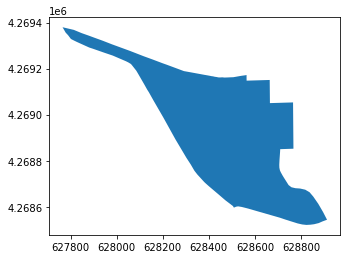

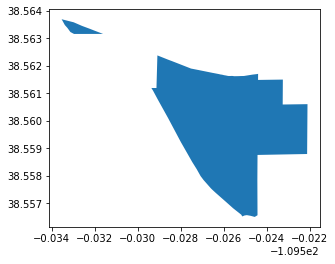

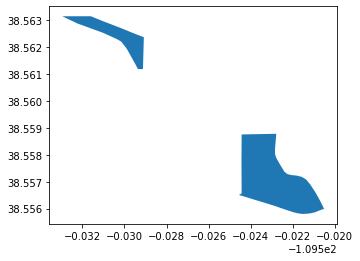

In [373]:
ut_vest[ut_vest['joinid'] == '10-02:70'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '10-02:470'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '10-02:570'].plot()

The above two precincts were merged with each other 

<AxesSubplot:>

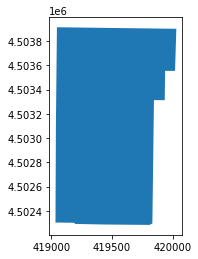

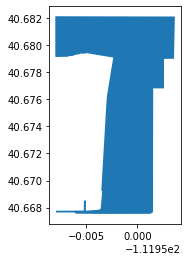

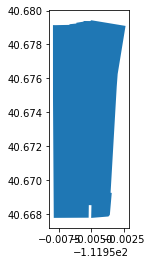

In [374]:
ut_vest[ut_vest['joinid'] == '18-TAY001'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-TAY001:01'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-TAY001:90'].plot()

The above two precincts were merged with each other 

<AxesSubplot:>

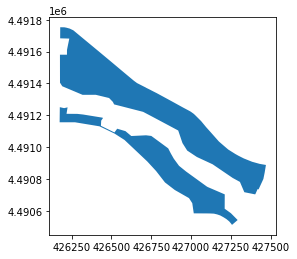

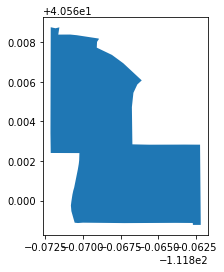

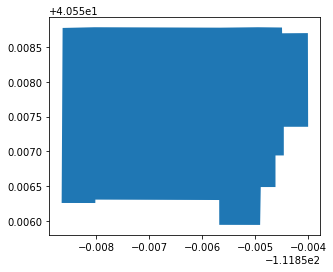

In [375]:
ut_vest[ut_vest['joinid'] == '18-WHT005'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-WHT004:00'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-WHT003:02'].plot()


The above two precincts were not merged with each other 

<AxesSubplot:>

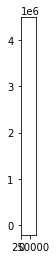

In [376]:
ax = ut_vest[ut_vest['joinid'] == '21-7.1.3'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '21-7:1'].plot(ax = ax,color="red")
combo_precinct_vista[combo_precinct_vista['joinid'] == '21-7:3'].plot(ax = ax,color="green")


<AxesSubplot:>

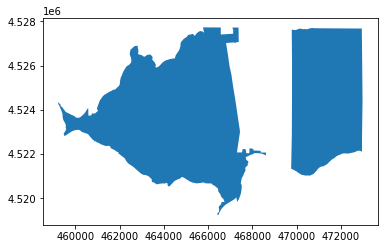

In [377]:
ut_vest[ut_vest['joinid'] == '22-HOYT18uninc'].plot()


<AxesSubplot:>

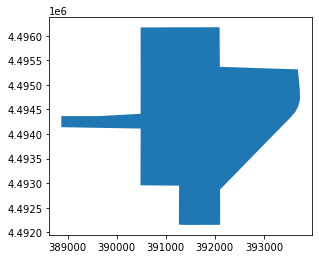

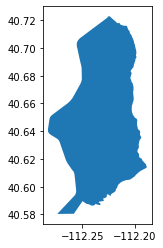

In [378]:
ut_vest[ut_vest['joinid'] == '23-ERD-02:1'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '23-ERD-12:0'].plot()

<AxesSubplot:>

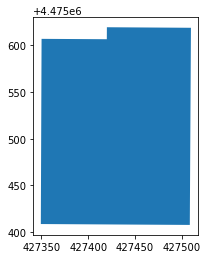

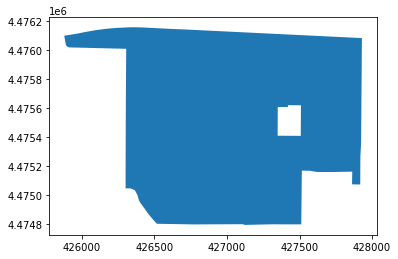

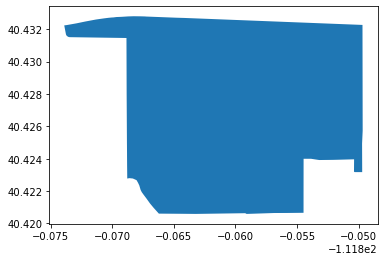

In [379]:
ut_vest[ut_vest['joinid'] == '25-LE12:UN'].plot()
ut_vest[ut_vest['joinid'] == '25-LE12'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '25-LE12'].plot()

The above two precincts were merged with each other 

<AxesSubplot:>

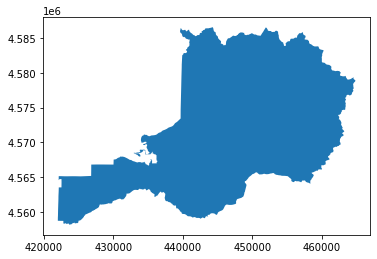

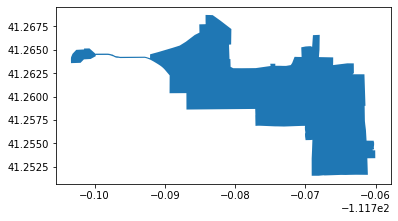

In [380]:
ut_vest[ut_vest['joinid'] == '29-HTV002'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '29-HTV001:R'].plot()

<AxesSubplot:>

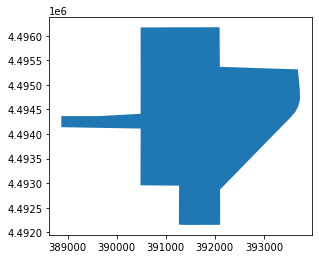

In [381]:
ut_vest[ut_vest['joinid'] == '23-ERD-02:1'].plot()
#combo_precinct_vista[combo_precinct_vista['joinid'] == '23-ERD-02:0'].plot()

### Load in manually created dictionary of name changes and merges to form VistaID

In [47]:
geo_dict = {
    '5-1001:DS1': '5-1001:DS1,SD1',
 '5-1001:SD1': '5-1001:DS1,SD1',
 '5-1001:SD2': '5-1001:DS2,SD2',
 '5-1001:DS2': '5-1001:DS2,SD2',
 '5-1002:MS3': '5-1002:MS3,SD3',
 '6-CF01:I-N-': '6-CF01',
 '7-RO92': '7-R092',
 '10-01:470': '10-01:70',
 '10-01:570': '10-01:70',
 '10-02:569': '10-02:69',
 '10-02:570': '10-02:70',
 '10-02:470': '10-02:70',
 '10-03:570': '10-03:70',
 '10-03:470': '10-03:70',
 '10-04:569': '10-04:69',
 '10-04:470': '10-04:70',
 '10-04:570': '10-04:70',
 '10-05:569': '10-05:69',
 '10-05:470': '10-05:70',
 '10-05:570': '10-05:70',
 '10-06:469': '10-06:69',
 '10-06:569': '10-06:69',
 '10-06:470': '10-06:70',
 '10-06:570': '10-06:70',
 '10-07:569': '10-07:69',
 '10-07:570': '10-07:70',
 '10-08:469': '10-08:69',
 '10-08:569': '10-08:69',
 '10-09:569': '10-09:69',
 '10-09:470': '10-09:70',
 '10-09:570': '10-09:70',
 '10-10:470': '10-10:70',
 '10-10:570': '10-10:70',
 '10-11:469': '10-11:69',
 '10-11:569': '10-11:69',
 '10-11:470': '10-11:70',
 '10-11:570': '10-11:70',
 '15-10:2': '15-10:4',
 '15-11:2': '15-11:4',
 '15-12:2': '15-12:4',
 '15-13:2': '15-13:5',
 '15-14:3': '15-14:5',
 '15-15:2': '15-15:5',
 '15-4:1': '15-4:2',
 '15-5:3': '15-5:2',
 '15-6:3': '15-6:2',
 '18-RIV001:00': '18-RIV001',
 '18-RIV004:00': '18-RIV004',
 '18-RIV005:00': '18-RIV005',
 '18-TAY001:01': '18-TAY001',
 '18-TAY001:90': '18-TAY001',
 '18-TAY002:00': '18-TAY002',
 '21-1:1': '21-1',
 '21-1:2': '21-1',
 '21-10:1': '21-10',
 '21-10:2': '21-10',
 '21-11:2': '21-11.2',
 '21-12:1': '21-12',
 '21-2:1': '21-2',
 '21-2:2': '21-2',
 '21-20:2': '21-20.2',
 '21-21:1': '21-21',
 '21-23:2': '21-23.2',
 '21-24:2': '21-24.2',
 '21-4:1': '21-4',
 '21-4:2': '21-4',
 '21-5:1': '21-5',
 '21-5:2': '21-5',
 '21-6:1': '21-6',
 '21-6:2': '21-6',
 '21-7:1': '21-7.1.3',
 '21-7:3': '21-7.1.3',
 '21-7:2': '21-7.2',
 '21-8:1': '21-8',
 '21-8:2': '21-8',
 '21-9:1': '21-9',
 '21-9:2': '21-9',
 '23-RV-01:1': '23-RV-01:1-01:2',
 '23-RV-01:2': '23-RV-01:1-01:2',
 '23-STK-01:1': '23-STK-01:1-01:2',
 '23-STK-01:2': '23-STK-01:1-01:2',
 '23-STK-02:1': '23-STK-02:1-02:2',
 '23-STK-02:2': '23-STK-02:1-02:2',
 '23-T-03:1': '23-T-03:1-03:2',
 '23-T-03:2': '23-T-03:1-03:2',
 '23-T-04:1': '23-T-04:1-04:2',
 '23-T-04:2': '23-T-04:1-04:2',
 '23-VRN-01:1': '23-VRN-01:1-01:2',
 '23-VRN-01:2': '23-VRN-01:1-01:2',
 '8-9:20': '8-9',
 '8-9:21': '8-9',
 '8-3:5': '8-3',
 '8-3:6': '8-3',
 '8-11:24': '8-11',
 '8-11:25': '8-11',
 '8-5:10': '8-5',
 '8-5:9': '8-5',
 '8-7:14': '8-7',
 '8-7:15': '8-7',
 '8-6:11': '8-6',
 '8-6:13': '8-6',
 '8-1:1': '8-1',
 '8-1:2': '8-1',
 '8-12:26': '8-12',
 '8-12:27': '8-12',
 '8-13:28': '8-13',
 '8-13:29': '8-13'
           }

### Apply and dissolve based on the dictionary of name changes in preparation for another join

In [384]:
combo_precinct_vista_copy = combo_precinct_vista
combo_precinct_vista_copy["joinid"] = combo_precinct_vista_copy["joinid"].map(geo_dict).fillna(combo_precinct_vista_copy["joinid"])
display(combo_precinct_vista_copy)
dissolved_geo = combo_precinct_vista_copy.dissolve(by='joinid')
display(dissolved_geo)

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,joinid
0,1,13,BW,BW,None,None,2012-01-01,None,kanerds,2012-02-02,{F856988C-74CA-415D-AC4B-2A2020023EC9},0.195803,0.001577,"POLYGON ((-111.65149 37.09008, -111.65157 37.0...",13-BW
1,2,25,OR20,OR20,None,2021.1,2021-03-02,None,AndreaB,2021-03-02,{893A863C-A9DA-4214-8E4D-11FF587BCFBB},0.044090,0.000095,"POLYGON ((-111.70145 40.31183, -111.70274 40.3...",25-OR20
2,3,18,SLC117:00,SLC117,00,None,2019-12-16,Salt Lake City,None,2019-12-16,{30563DA7-3B62-427D-A0A5-1460FC75243B},0.039456,0.000041,"POLYGON ((-111.83496 40.74981, -111.83440 40.7...",18-SLC117:00
3,4,27,COHV28,COHV28,None,None,2012-01-01,None,nancy.lucchetti,2019-02-25,{BF88FEB3-58B4-4952-AE30-9BAE88CFB519},2.571008,0.063659,"POLYGON ((-113.26559 37.19438, -113.26488 37.1...",27-COHV28
4,5,18,COT004:02,COT004,02,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{F45718CC-DFFA-4FAD-9BF8-7081A6F4E942},0.024309,0.000026,"POLYGON ((-111.82472 40.63447, -111.82475 40.6...",18-COT004:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,3043,29,PLC002:B,PLC002,B,None,2021-02-22,None,None,2021-02-22,{D2A4DB59-F3AF-4B70-A6CB-D91C853A732F},0.234410,0.000769,"MULTIPOLYGON (((-112.05876 41.33589, -112.0589...",29-PLC002:B
3043,3044,18,TAY041:00,TAY041,00,None,2019-12-16,Taylorsville,None,2019-12-16,{C8BAAF11-5436-49CD-8A9F-2FBCF5CEBDED},0.036616,0.000062,"POLYGON ((-111.93201 40.64322, -111.93195 40.6...",18-TAY041:00
3044,3045,18,MIL032:01,MIL032,01,None,2019-12-16,Millcreek,None,2019-12-16,{97F6DDC2-7C48-4874-88F2-A363691EF564},0.060945,0.000100,"POLYGON ((-111.81371 40.71131, -111.81371 40.7...",18-MIL032:01
3045,3046,18,COT038:00,COT038,00,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{CFB98657-4740-4B53-A6FF-BB69FE5CD0EB},0.045916,0.000078,"POLYGON ((-111.78793 40.58628, -111.78788 40.5...",18-COT038:00


,geometry,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area
joinid,,,,,,,,,,,,,,
1-BV01:1,"POLYGON ((-112.61943 38.28272, -112.61932 38.2...",116,1,BV01:1,BV01,1,2013-1,2012-01-01,None,None,2013-10-16,{0FA59E15-AE99-4036-BAC2-9B52BD96C41E},0.078745,0.000202
1-BV02:1,"POLYGON ((-112.64838 38.30108, -112.63701 38.3...",1061,1,BV02:1,BV02,1,2013-1,2012-01-01,None,None,2013-10-16,{42E04D64-AB96-467C-8CA7-9C6CCB6BDC3C},0.226984,0.000838
1-BV03:1,"MULTIPOLYGON (((-112.65342 38.22070, -112.6533...",1017,1,BV03:1,BV03,1,2013-1,2013-10-16,None,None,2013-10-16,{1C4CBC52-7A01-4F50-AB5B-F3FC2BEB34A6},0.323054,0.000728
1-BV03:2,"MULTIPOLYGON (((-112.62208 38.31248, -112.6215...",420,1,BV03:2,BV03,2,2013-1,2013-10-16,None,None,2013-10-16,{D02BB6DB-1A3E-4369-BC75-7B0AE02820FE},2.428363,0.077798
1-BV04:1,"POLYGON ((-112.51533 38.50140, -112.51560 38.5...",2966,1,BV04:1,BV04,1,2013-1,2012-01-01,None,None,2013-10-16,{A9ECB9F0-C95B-497D-A358-C9CB6664DBE9},1.435445,0.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-PA8:1,"POLYGON ((-112.44624 37.81799, -112.45084 37.8...",855,9,PA8:1,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{636E5665-1302-47E1-939F-401CA0E16883},0.118368,0.000351
9-PA8:2,"POLYGON ((-112.44624 37.81799, -112.44272 37.8...",913,9,PA8:2,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{D253077A-9D44-4537-B029-6246F8D8051D},1.826924,0.069706
9-TI9:1,"POLYGON ((-110.20313 37.94548, -110.20329 37.9...",1059,9,TI9:1,TI9,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{D8704BC5-234B-4139-80C1-D03372242AE0},3.416384,0.407979


### Perform the final merge using the dissolved geo_dict 

In [385]:
left_only_geo2_copy = left_only_geo2.drop(columns = ['_merge','OBJECTID','CountyID','VistaID','PrecinctID','SubPrecinc','VersionNbr','EffectiveD','AliasName','Comments','RcvdDate','GlobalID','SHAPE_Leng','SHAPE_Area','geometry','_merge'])
print(len(left_only_geo2_copy))
print(len(dissolved_geo))
join_attempt_geo3 = pd.merge(left_only_geo2_copy, dissolved_geo, how="outer",on="joinid",indicator=True)
print(join_attempt_geo3["_merge"].value_counts())

merged_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="both"]
right_only_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="right_only"]
right_only_geo3_sorted = right_only_geo3.sort_values('joinid')
left_only_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="left_only"]

#left_only_geo3.to_csv("./only_vest_geo3.csv")
#right_only_geo3_sorted.to_csv("./only_source_geo2.csv")



84
2887
right_only    2819
both            68
left_only       16
Name: _merge, dtype: int64


In [386]:
ut_geo_sorted = ut_geo
ut_geo_sorted['joinid'] = ut_geo_sorted['CountyID'].astype(str) + '-' + ut_geo_sorted['VistaID']
ut_geo_sorted = ut_geo_sorted.sort_values('joinid')
#ut_geo_sorted.to_csv("./ut_geo.csv")



### Clean up the column structure of the final dataframe to prepare for validation

In [387]:
#print(merged_geo)
#print(merged_geo2)
#print(merged_geo3)

merged_geo_clean = merged_geo.drop(columns = ['SubPrecinc', 'VersionNbr', 'EffectiveD', 'AliasName','Comments','RcvdDate', 'GlobalID', '_merge','SHAPE_Leng','SHAPE_Area','totals','OBJECTID','VistaID'])
merged_geo2_clean = merged_geo2.drop(columns = ['SubPrecinc', 'VersionNbr', 'EffectiveD', 'AliasName','Comments','RcvdDate', 'GlobalID', '_merge','SHAPE_Leng','SHAPE_Area','OBJECTID','VistaID', 'PrecinctID'])
merged_geo3_clean = merged_geo3.drop(columns = ['SubPrecinc', 'VersionNbr', 'EffectiveD', 'AliasName','Comments','RcvdDate', 'GlobalID', '_merge','SHAPE_Leng','SHAPE_Area','OBJECTID','VistaID', 'PrecinctID'])

merged_geo2_clean.rename(columns = {"CountyID": "CountyID_y",
                                   "geometry": "geometry_y"}, 
          inplace = True)
merged_geo3_clean.rename(columns = {"CountyID": "CountyID_y",
                                   "geometry": "geometry_y"}, 
          inplace = True)

display(merged_geo_clean)
display(merged_geo2_clean)
display(merged_geo3_clean)


merged_df = (pd.concat([merged_geo_clean, merged_geo2_clean, merged_geo3_clean])).reset_index()
merged_df.drop(columns = 'index', inplace= True)
#merged_df.to_csv("./merged_df.csv")

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
1,29.0,FRW001,29-FRW001,476.0,79.0,3.0,11.0,18.0,1.0,"POLYGON ((415532.900 4571511.100, 415555.020 4...",29-FRW001,18,79,3,11,1,476,"POLYGON ((-112.00880 41.29063, -112.00853 41.2...",29.0
2,29.0,FRW002,29-FRW002,304.0,132.0,5.0,12.0,24.0,1.0,"POLYGON ((414104.540 4571410.010, 414104.310 4...",29-FRW002,24,132,5,12,1,304,"POLYGON ((-112.02584 41.28957, -112.02584 41.2...",29.0
3,29.0,FRW003,29-FRW003,583.0,129.0,11.0,29.0,24.0,3.0,"POLYGON ((412691.000 4573709.660, 412690.930 4...",29-FRW003,24,129,11,29,3,583,"POLYGON ((-112.04305 41.31013, -112.04305 41.3...",29.0
4,29.0,FRW004,29-FRW004,652.0,143.0,12.0,35.0,32.0,2.0,"POLYGON ((413427.540 4576634.630, 413436.480 4...",29-FRW004,32,143,12,35,2,652,"POLYGON ((-112.04482 41.33610, -112.04482 41.3...",29.0
5,29.0,HPR001,29-HPR001,454.0,82.0,10.0,14.0,21.0,2.0,"POLYGON ((405841.300 4563000.630, 405934.010 4...",29-HPR001,21,82,10,14,2,454,"POLYGON ((-112.10285 41.18622, -112.10286 41.1...",29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2.0,WLRD,2-WLRD,609.0,126.0,13.0,11.0,26.0,5.0,"POLYGON ((387979.000 4593096.400, 388079.300 4...",2-WLRD,26,126,13,11,5,609,"POLYGON ((-112.34051 41.47832, -112.34009 41.4...",2.0
2325,8.0,8,8-8,330.0,55.0,20.0,9.0,12.0,0.0,"POLYGON ((501561.880 4368910.840, 501926.760 4...",8-8,12,55,20,9,0,330,"MULTIPOLYGON (((-109.52932 37.30532, -109.5291...",8.0
2329,8.0,2,8-2,307.0,32.0,16.0,6.0,7.0,1.0,"POLYGON ((475013.780 4333510.100, 475021.040 4...",8-2,7,32,16,6,1,308,"MULTIPOLYGON (((-109.31906 37.85842, -109.3191...",8.0
2332,8.0,10,8-10,297.0,43.0,11.0,10.0,6.0,0.0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,"MULTIPOLYGON (((-109.69054 37.21803, -109.6898...",8.0


,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,CountyID_y,geometry_y
2,29.0,RIV002,29-RIV002,340.0,209.0,10.0,15.0,17.0,0.0,"POLYGON ((417711.180 4560608.420, 417713.140 4...",29-RIV002,17,209,10,15,0,340,29.0,"POLYGON ((-111.98131 41.19266, -111.98129 41.1..."
3,29.0,RIV003,29-RIV003,338.0,175.0,6.0,27.0,27.0,3.0,"POLYGON ((415896.380 4560210.520, 415922.730 4...",29-RIV003,27,175,6,27,3,338,29.0,"POLYGON ((-112.00258 41.18885, -112.00195 41.1..."
9,3.0,LOG01:CSD,3-LOG01:CSD,42.0,44.0,1.0,3.0,1.0,0.0,"POLYGON ((430971.240 4619310.810, 430995.300 4...",3-LOG01:CSD,1,44,1,3,0,42,3.0,"POLYGON ((-111.82992 41.72261, -111.82963 41.7..."
10,3.0,LOG01:I,3-LOG01:I,114.0,104.0,8.0,10.0,4.0,0.0,"POLYGON ((431191.910 4620064.060, 431184.290 4...",3-LOG01:I,4,104,8,10,0,114,3.0,"POLYGON ((-111.82735 41.72941, -111.82742 41.7..."
11,3.0,LOG27:17C,3-LOG27:17C,1.0,0.0,0.0,0.0,2.0,0.0,"MULTIPOLYGON (((427048.990 4614431.440, 427059...",3-LOG27:17C,2,0,0,0,0,1,3.0,"MULTIPOLYGON (((-111.87647 41.67832, -111.8763..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,26.0,55:1,26-55:1,154.0,69.0,0.0,4.0,7.0,1.0,"POLYGON ((461224.270 4481329.260, 461224.280 4...",26-55:1,7,69,0,4,1,154,26.0,"POLYGON ((-111.45750 40.48175, -111.45750 40.4..."
291,12.0,NE03:5,12-NE03:5,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((345796.490 4394130.360, 363449.220 4...",12-NE03:5,0,0,0,0,0,0,12.0,"POLYGON ((-112.79819 39.68310, -112.59235 39.6..."
292,17.0,UNINH,17-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((476910.860 4643876.500, 476898.550 4...",17-UNINH,0,0,0,0,0,0,17.0,"POLYGON ((-111.27857 41.94653, -111.27871 41.9..."
293,25.0,SR09:UN,25-SR09:UN,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((421380.630 4464308.450, 421371.490 4...",25-SR09:UN,0,0,0,0,0,0,25.0,"POLYGON ((-111.92545 40.32561, -111.92546 40.3..."


,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
7,5.0,"1001:DS1,SD1","5-1001:DS1,SD1",46.0,22.0,0.0,1.0,0.0,0.0,"POLYGON ((664004.500 4540665.600, 664047.300 4...","5-1001:DS1,SD1",0,22,0,1,0,46,"POLYGON ((-109.47020 40.75565, -109.47007 40.7...",5.0
8,5.0,"1001:DS2,SD2","5-1001:DS2,SD2",28.0,6.0,0.0,0.0,0.0,0.0,"POLYGON ((631806.960 4539575.320, 631790.700 4...","5-1001:DS2,SD2",0,6,0,0,0,28,"POLYGON ((-109.43310 40.99575, -109.43315 40.9...",5.0
9,5.0,"1002:MS3,SD3","5-1002:MS3,SD3",67.0,9.0,0.0,3.0,4.0,0.0,"POLYGON ((607236.150 4538845.570, 607237.900 4...","5-1002:MS3,SD3",4,9,0,3,0,67,"POLYGON ((-109.72507 40.99375, -109.72505 40.9...",5.0
10,6.0,CF01,6-CF01,317.0,134.0,11.0,12.0,22.0,0.0,"POLYGON ((416489.110 4549534.150, 416489.350 4...",6-CF01,22,134,11,12,0,317,"POLYGON ((-112.00419 41.10354, -112.00189 41.1...",6.0
11,7.0,R092,7-R092,53.0,4.0,2.0,2.0,4.0,0.0,"MULTIPOLYGON (((582229.870 4461736.360, 582232...",7-R092,4,4,2,2,0,53,"MULTIPOLYGON (((-110.05909 40.27309, -110.0596...",7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,8.0,5,8-5,462.0,60.0,21.0,7.0,6.0,1.0,"POLYGON ((480702.590 4361802.330, 480878.380 4...",8-5,6,59,21,7,1,262,"POLYGON ((-111.22210 39.40263, -111.22195 39.4...",8.0
80,8.0,7,8-7,269.0,45.0,6.0,8.0,6.0,1.0,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,269,"POLYGON ((-110.98388 39.26838, -110.98381 39.2...",8.0
81,8.0,6,8-6,222.0,39.0,14.0,4.0,5.0,0.0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,"POLYGON ((-111.02013 39.23149, -111.01997 39.2...",8.0
82,8.0,1,8-1,109.0,16.0,7.0,2.0,5.0,0.0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,"POLYGON ((-110.98149 39.04336, -110.98075 39.0...",8.0


In [388]:
display(merged_df[merged_df["CountyID_x"] == 4.0])

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
293,4.0,19,4-19,326.0,95.0,20.0,13.0,15.0,2.0,"POLYGON ((521528.550 4377617.190, 522335.170 4...",4-19,15,95,20,13,2,326,"POLYGON ((-110.74945 39.54797, -110.74006 39.5...",4.0
294,4.0,27,4-27,142.0,47.0,4.0,4.0,8.0,0.0,"POLYGON ((513792.780 4383450.090, 514213.760 4...",4-27,8,47,4,4,0,142,"POLYGON ((-110.83936 39.60068, -110.83446 39.6...",4.0
295,4.0,34,4-34,264.0,80.0,8.0,4.0,12.0,1.0,"POLYGON ((519041.740 4383241.640, 518636.830 4...",4-34,12,80,8,4,1,264,"MULTIPOLYGON (((-110.78294 39.59921, -110.7841...",4.0
296,4.0,36,4-36,237.0,76.0,12.0,11.0,10.0,2.0,"POLYGON ((517995.870 4381850.390, 518182.690 4...",4-36,10,76,12,11,2,237,"POLYGON ((-110.79045 39.58619, -110.78827 39.5...",4.0
297,4.0,37,4-37,327.0,160.0,20.0,19.0,26.0,1.0,"POLYGON ((523777.460 4406970.830, 523776.320 4...",4-37,26,160,20,19,1,327,"POLYGON ((-110.72221 39.81239, -110.72223 39.8...",4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,4.0,31,4-31,143.0,66.0,11.0,4.0,6.0,1.0,"POLYGON ((516201.520 4384284.790, 516202.490 4...",4-31,6,66,11,4,1,143,"POLYGON ((-110.81128 39.60816, -110.81128 39.6...",4.0
2090,4.0,32,4-32,225.0,95.0,8.0,8.0,3.0,1.0,"POLYGON ((516698.340 4384466.690, 516867.090 4...",4-32,3,95,8,8,1,225,"POLYGON ((-110.80549 39.60979, -110.80353 39.6...",4.0
2091,4.0,33,4-33,222.0,87.0,10.0,8.0,11.0,0.0,"POLYGON ((516205.670 4385504.520, 516506.790 4...",4-33,11,87,10,8,0,222,"POLYGON ((-110.81120 39.61915, -110.80770 39.6...",4.0
2092,4.0,40,4-40,83.0,37.0,6.0,6.0,0.0,0.0,"POLYGON ((519902.030 4377005.400, 519911.080 4...",4-40,0,37,6,6,0,83,"POLYGON ((-110.76839 39.54249, -110.76834 39.5...",4.0


### Dissolve non-unique joinid's

In [389]:
print(len(ut_vest) - len(merged_df))
print(len(merged_df.joinid.unique()))
print(len(merged_df))

merged_df_dissolve = merged_df.groupby(by='joinid')
print(len(merged_df_dissolve))

-16
2321
2353
2321


In [43]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["joinid"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["joinid"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["joinid"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

### Run the validation algorithm on the races and check outputs

In [391]:
races = ['G18USSCAAL','G18USSDWIL','G18USSIMCC','G18USSLBOW','G18USSOWRI','G18USSRROM']

merged_df = merged_df.astype({'G18USSCAAL_x':int,'G18USSDWIL_x':int,'G18USSIMCC_x':int,'G18USSLBOW_x':int,'G18USSOWRI_x':int,'G18USSRROM_x':int,
                             'G18USSCAAL_y':int,'G18USSDWIL_y':int,'G18USSIMCC_y':int,'G18USSLBOW_y':int,'G18USSOWRI_y':int,'G18USSRROM_y':int,
                             })
validater_row(merged_df.sort_values("joinid"),races)

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
2108,12.0,NE02:5,12-NE02:5,123.0,9.0,1.0,0.0,1.0,3.0,"POLYGON ((428643.160 4394758.930, 428643.150 4...",12-NE02:5,3,1,0,1,123,9,"POLYGON ((-111.83233 39.69971, -111.83233 39.6...",12.0


G18USSCAAL ...............................................................12-NE02:5 (V) ....1  (S)....3 (D):    2
G18USSDWIL ...............................................................12-NE02:5 (V) ....9  (S)....1 (D):   -8
G18USSIMCC ...............................................................12-NE02:5 (V) ....1  (S)....0 (D):   -1
G18USSLBOW ...............................................................12-NE02:5 (V) ....0  (S)....1 (D):    1
G18USSOWRI ...............................................................12-NE02:5 (V) ....3  (S)..123 (D):  120
G18USSRROM ...............................................................12-NE02:5 (V) ..123  (S)....9 (D): -114
G18USSIMCC ...................................................................26-10 (V) ....4  (S)....6 (D):    2
G18USSLBOW ...................................................................26-10 (V) ....6  (S)....4 (D):   -2
G18USSCAAL ...................................................................26-21 (V) 

### Validate geometries

In [ ]:
source_geoms = gp.GeoDataFrame(merged_df,geometry="geometry_x")
vest_geoms = gp.GeoDataFrame(merged_df,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

### Display validation data

In [ ]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"joinid"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")